# Advanced Regression

__Assignment Submitted by:__ Janarthanan Balasubramanian

__Client:__ Surprise Housing (a US-based housing company)

__Business Understanding:__ Surprise Housing purchase houses at price below their actual values and flip them on a a higher price. The company uses data analytics to make their decisions on which house to purchase and at what price. They want to enter the Australian market and has acquired the data from the sale of houses in Australia to identify prospective properties to buy. The management wants to understand the pricing dynamics of the new market. 

__Assignment:__ Build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not. The company wants to know:

 - Which variables are significant in predicting the price of a house?
 - How well those variables describe the price of a house?
 - Determine the optimal value of lambda for ridge and lasso regression.

This model will then be used by the management to understand how exactly the prices vary with the variables. Accordingly, they can manipulate the strategy of the firm and concentrate on areas that will yield high returns. 

---

In [1]:
import os
import random as rd

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
%%html
<style> table {float:left} </style>

In [4]:
data_path = os.getcwd()

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.rcParams.update(plt.rcParamsDefault)

In [6]:
sns.set()

In [7]:
def visualize_categorical_variable(data = None, col = None, target = None):
     
    print(); print('Variable       : ' + col)
    
    # Printing the Statistics
    
    tempdf = pd.DataFrame(data[col].value_counts()).reset_index()
    tempdf.rename(columns = { 'index' : col, col : 'Count'}, inplace = True)
    tempdf['Percentage'] = round((tempdf['Count'] / len(data.index) * 100), 2)
    
    levels = list(tempdf[col].astype('str')  + ' (' + tempdf['Count'].astype('str') + ')'); 
    print('Levels         :', len(levels)); print(); print(levels); print(); print('*' * 80); print()    
        
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        
    # Visualization - Univariate
    
    ax = sns.barplot(data = tempdf, x = col, y = 'Count', ax = axes[0])
    if len(levels) > 7: ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax.set_title('Levels in ' + col, fontsize = 14)
    
    # Visualization - Bivariate (against the Target)
    
    ax = sns.barplot(data = df, x = col, y = target, ax = axes[1])
    if len(levels) > 7: ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax.set_title('Average ' + target, fontsize = 14)
    
    ax = sns.boxplot(data = df, x = col, y = 'SalePrice', ax = axes[2])
    if len(levels) > 7: ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax.set_title(target + ' Distribution', fontsize = 14)
    
    plt.show()
    
    print('*' * 80); print()

---

# Section 1: Exploratory Data Analysis

## 1.1. Reading and Understanding the Data

In [8]:
df = pd.read_csv(data_path + '\\train.csv', encoding = "ISO-8859-1")

In [9]:
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice
0   1          60       RL         65.0     8450   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2003          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace       196.0        Gd        TA      PConc       Gd       TA           No          GLQ         706          Unf           0        150          856    GasA        Ex          Y      SBrkr       856       854             0       1710             1             0         2         1             3             1          Gd             8        Typ           0         NaN     Attchd       2003.0          RFn           2         548         TA         TA          Y           0           61              0          0            0         0    NaN   NaN         NaN        0       2    2008       WD        Normal     208500
1   2          20       RL         80.0     9600   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story            6            8       1976          1976     Gable  CompShg     MetalSd     MetalSd       None         0.0        TA        TA     CBlock       Gd       TA           Gd          ALQ         978          Unf           0        284         1262    GasA        Ex          Y      SBrkr      1262         0             0       1262             0             1         2         0             3             1          TA             6        Typ           1          TA     Attchd       1976.0          RFn           2         460         TA         TA          Y         298            0              0          0            0         0    NaN   NaN         NaN        0       5    2007       WD        Normal     181500
2   3          60       RL         68.0    11250   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2001          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace       162.0        Gd        TA      PConc       Gd       TA           Mn          GLQ         486          Unf           0        434          920    GasA        Ex          Y      SBrkr       920       866             0       1786             1             0         2         1             3             1          Gd             6        Typ           1          TA     Attchd       2001.0          RFn           2         608         TA         TA          Y           0           42              0          0            0         0    NaN   NaN         NaN        0       9    2008       WD        Normal     223500
3   4          70       RL         60.0     9550   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam     2Story            7            5       1915          1970     Gable  CompShg     Wd Sdng     Wd Shng       None         0.0        TA        TA     BrkTil       TA       Gd           No          ALQ         216          Unf           0        540          756   

In [10]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
  

In [11]:
# check the shape of the data set (number of rows and columns)

print('Number of rows: ', df.shape[0])
print('Number of cols: ', df.shape[1])

Number of rows:  1460
Number of cols:  81


In [12]:
# check data type, unique values, null values and null percentage

stats = pd.concat([pd.DataFrame(df.dtypes), 
                   pd.DataFrame(df.nunique()), 
                   pd.DataFrame(df.isnull().sum()),
                   pd.DataFrame(round(100 * (df.isnull().sum() / len(df.index)), 2))], axis = 1).reset_index()

stats.columns = ['Variable', 'Data Type', 'Unique Values', 'Null Values', 'Null Percentage']

In [13]:
stats.head()

Variable Data Type  Unique Values  Null Values  Null Percentage
0           Id     int64           1460            0             0.00
1   MSSubClass     int64             15            0             0.00
2     MSZoning    object              5            0             0.00
3  LotFrontage   float64            110          259            17.74
4      LotArea     int64           1073            0             0.00

In [14]:
non_numeric = []; numeric = []

for column in df.columns:
    if df[column].dtypes == 'object': non_numeric.append(column)
    else: numeric.append(column)

print('Non-Numeric columns:\n', non_numeric)
print('Numeric columns:\n', numeric)

Non-Numeric columns:
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Numeric columns:
 ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'Gar

In [15]:
# we will set the Id as the index of the data frame

df.set_index('Id', inplace = True)

In [16]:
for col in non_numeric:

    print('Variable       : ' + col)
           
    nullval = df[col].isnull().sum()
    percent = round((nullval / len(df.index)) * 100, 2)
    if nullval != 0: print('Null Values    :', nullval, '-', percent, '%')
    else: print('Null Values    : None')
        
    tempdf = pd.DataFrame(df[col].value_counts()).reset_index()
    tempdf.rename(columns = { 'index' : col, col : 'Count'}, inplace = True)
    tempdf['Percentage'] = round((tempdf['Count'] / len(df.index) * 100), 2)
      
    levels = list(tempdf[col].astype('str')  + ' (' + tempdf['Count'].astype('str') + ')'); 
    print('Levels         :', len(levels)); print(); print(levels); print(); print('*' * 80); print()  

Variable       : MSZoning
Null Values    : None
Levels         : 5

['RL (1151)', 'RM (218)', 'FV (65)', 'RH (16)', 'C (all) (10)']

********************************************************************************

Variable       : Street
Null Values    : None
Levels         : 2

['Pave (1454)', 'Grvl (6)']

********************************************************************************

Variable       : Alley
Null Values    : 1369 - 93.77 %
Levels         : 2

['Grvl (50)', 'Pave (41)']

********************************************************************************

Variable       : LotShape
Null Values    : None
Levels         : 4

['Reg (925)', 'IR1 (484)', 'IR2 (41)', 'IR3 (10)']

********************************************************************************

Variable       : LandContour
Null Values    : None
Levels         : 4

['Lvl (1311)', 'Bnk (63)', 'HLS (50)', 'Low (36)']

********************************************************************************

Variable       :

---

## 1.2. Dealing with Null Values

In [17]:
%matplotlib inline

In [18]:
# List the columns with null values - note that these are NA values from the data which means Not Applicable

stats = stats[stats['Null Percentage'] > 0].sort_values(by = 'Null Percentage', ascending = False)

Text(0.5, 1.0, 'Null Value Percentage in each Feature')

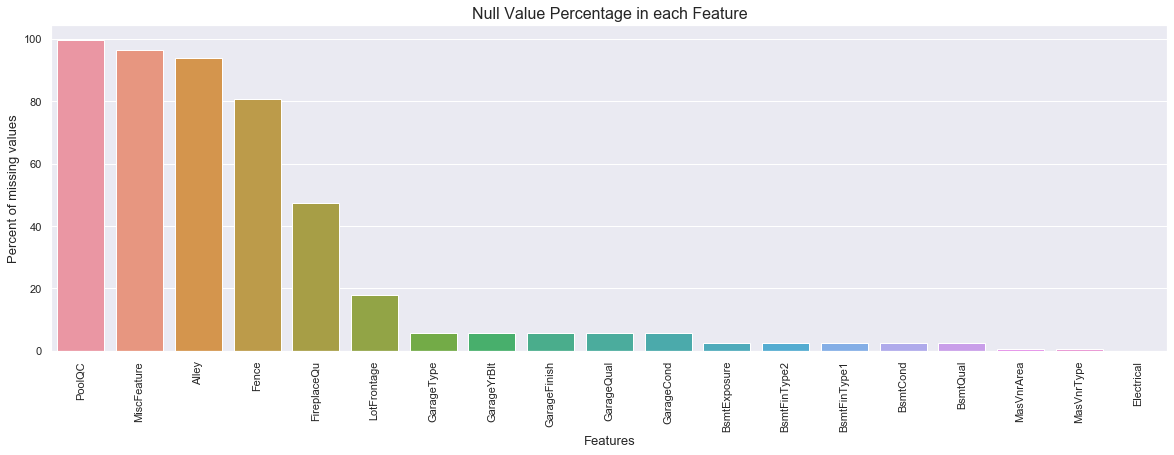

In [19]:
f, ax = plt.subplots(figsize = (20, 6))
plt.xticks(rotation='90')
sns.barplot(data = stats, x = 'Variable', y = 'Null Percentage')
plt.xlabel('Features', fontsize = 13)
plt.ylabel('Percent of missing values', fontsize = 13)
plt.title('Null Value Percentage in each Feature', fontsize = 16)

In [20]:
# drop columns with percentage of null values > 80% 
# we can also impute with NA, but due to low variance, the field may not contribute to the model

df.drop(columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence'], inplace = True)

In [21]:
# LotFrontage: Linear feet of street connected to property - we will assume it to be 0 when it is null

df.LotFrontage.fillna(0, inplace = True)

In [22]:
# null value for Garage related columns are due to those houses having no garage

df[['GarageYrBlt', 'GarageType', 'GarageQual', 
    'GarageFinish', 'GarageCond', 'GarageCars', 'GarageArea']].loc[df['GarageType'].isnull() == True].head(5)

GarageYrBlt GarageType GarageQual GarageFinish GarageCond  GarageCars  GarageArea
Id                                                                                   
40          NaN        NaN        NaN          NaN        NaN           0           0
49          NaN        NaN        NaN          NaN        NaN           0           0
79          NaN        NaN        NaN          NaN        NaN           0           0
89          NaN        NaN        NaN          NaN        NaN           0           0
90          NaN        NaN        NaN          NaN        NaN           0           0

In [23]:
# if there are no garages, we need to impute with NA for the null values

df.GarageType.fillna('NA', inplace = True)
df.GarageQual.fillna('NA', inplace = True)
df.GarageFinish.fillna('NA', inplace = True)
df.GarageCond.fillna('NA', inplace = True)
df.GarageYrBlt.fillna(0, inplace = True)

In [24]:
# null value for basement related columns is due to the house having no basement

df[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 
'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']].loc[(df['BsmtExposure'].isnull() == True) | 
                                                    (df['BsmtFinType2'].isnull() == True)].head()

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
Id                                                                                                                                      
18       NaN      NaN          NaN          NaN           0          NaN           0          0            0             0             0
40       NaN      NaN          NaN          NaN           0          NaN           0          0            0             0             0
91       NaN      NaN          NaN          NaN           0          NaN           0          0            0             0             0
103      NaN      NaN          NaN          NaN           0          NaN           0          0            0             0             0
157      NaN      NaN          NaN          NaN           0          NaN           0          0            0             0             0

However 2 records need special treatment - the house has a basement, but the values are missing

In [25]:
df[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
    'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 
    'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']].iloc[[332, 948]]

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
Id                                                                                                                                      
333       Gd       TA           No          GLQ        1124          NaN         479       1603         3206             1             0
949       Gd       TA          NaN          Unf           0          Unf           0        936          936             0             0

In [26]:
# Id: 333 (row index = 332) - Update BsmtFinType2 as Unf

df.iloc[332, df.columns.get_loc('BsmtFinType2')] = 'Unf'

In [27]:
# Id: 949 (row index = 948) - Update BsmtExposure as No

df.iloc[948, df.columns.get_loc('BsmtExposure')] = 'No'

In [28]:
# if there are no basements, we need to impute with NA for the null values

df.BsmtFinType2.fillna('NA', inplace = True)
df.BsmtExposure.fillna('NA', inplace = True)
df.BsmtQual.fillna('NA', inplace = True)
df.BsmtCond.fillna('NA', inplace = True)
df.BsmtFinType1.fillna('NA', inplace = True)

In [29]:
# records with null value for MasVnrType and MasVnrArea may be due to the house not having Masonry veneer

df.MasVnrType.fillna('None', inplace = True)
df.MasVnrArea.fillna(0, inplace = True)
df.FireplaceQu.fillna('NA', inplace = True)

In [30]:
# record with a null value for Electrical - impute with mode - SBrkr

df.Electrical.fillna('SBrkr', inplace = True)

In [31]:
# check whether there are any further null values

df.isnull().sum()[df.isnull().sum() != 0]

Series([], dtype: int64)

__There are no null values in the dataset.__

---

## 1.3. Target Variable (Sale Price) - Identifying Outliers

The target variable is the Sale Price. Let us study the target variable, visualize it and see whether there are any outliers. An outlier is a data point that is distant from other similar points. They may be due to variability in the measurement or in the system behavior or a fradulent behavior or may indicate a human error or instrument error or may be due to natural deviations in populations (i.e. a sample may have been contaminated with elements from outside the population being examined). 

In [32]:
from scipy.stats import probplot

In [33]:
%matplotlib inline

In [34]:
# The SalePrice is the target variable and is numeric

target = ['SalePrice']

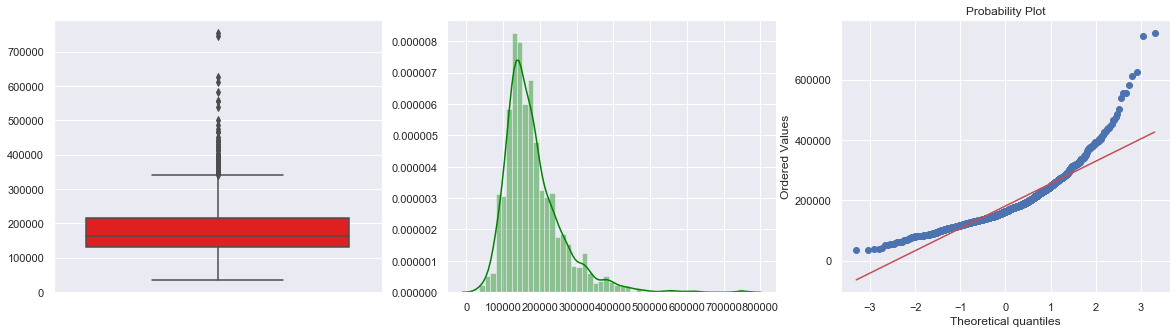

In [35]:
plt.figure(figsize = (20, 5))
plt.subplot(1,3,1)
sns.boxplot(data = df, y = target, color = 'red')
plt.subplot(1,3,2)
sns.distplot(df[target], hist = True, color = 'green')
plt.subplot(1,3,3)
probplot(df.SalePrice, plot = plt)
plt.show()

In [36]:
df[target].describe(percentiles = [.10, .25, .5, .75, .85, .95, .99]).T

count          mean           std      min       10%       25%       50%       75%       85%       95%        99%       max
SalePrice  1460.0  180921.19589  79442.502883  34900.0  106475.0  129975.0  163000.0  214000.0  250000.0  326100.0  442567.01  755000.0

We see that there are few outliers and the distribution is skewed to the right. Dropping outliers can be done only in extreme conditions. We should ensure that the outlier is a measurement error. When we drop data, we lose information in terms of the variability in data. When we have too many observations and outliers are few, then we can think of dropping these observations. In our data set we have only 1460 observations and 1% of the records are having values greater than 450000. 99 percent of the houses are in the range of 34900 - 442567 and there are few outliers (around 14 records). __We will not remove the outliers.__ But we can convert the variable to logarithmic scale. On converting to logarithmic scale, the distribution becomes normal. This will also boost the performance of the model.

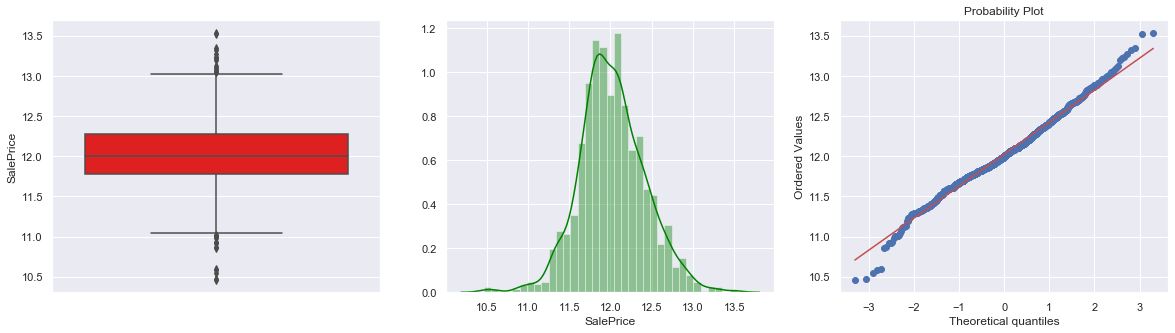

In [37]:
plt.figure(figsize = (20, 5))
plt.subplot(1,3,1)
sns.boxplot(data = df, y = np.log(df['SalePrice']), color = 'red')
plt.subplot(1,3,2)
sns.distplot(np.log(df['SalePrice']), hist = True, color = 'green')
plt.subplot(1,3,3)
probplot(np.log(df['SalePrice']), plot = plt)
plt.show()

In [38]:
df['SalePriceLog'] = np.log(df['SalePrice'])

---

## 1.4. Dealing with Years - Convert to Age

There are 3 variables with years. The year in which the house was built (YearBuilt), the year in which it was remodeled (YearRemodAdd) and the year in which the Garage was built (GarageYrBlt). For our convenience, we will bin it for visualization. Also we have the Year Sold (YrSold) and Month Sold (MoSold). 

In [39]:
%matplotlib inline

In [40]:
years = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']

In [41]:
bins = [0, 1900, 1951, 2001, 2020]
lbls = ['Before 1900', '1901-1950', '1951-2000', 'After 2000']

df['YrBuilt']     = pd.cut(df.YearBuilt, bins, labels = lbls).astype(str)
df['YrRemodAdd']  = pd.cut(df.YearRemodAdd, bins, labels = lbls).astype(str)
df['YrGarageBlt'] = pd.cut(df.GarageYrBlt, bins, labels = lbls).astype(str)

In [42]:
years = ['YrBuilt', 'YrRemodAdd', 'YrGarageBlt']


Variable       : YrBuilt
Levels         : 4

['1951-2000 (772)', 'After 2000 (344)', '1901-1950 (319)', 'Before 1900 (25)']

********************************************************************************



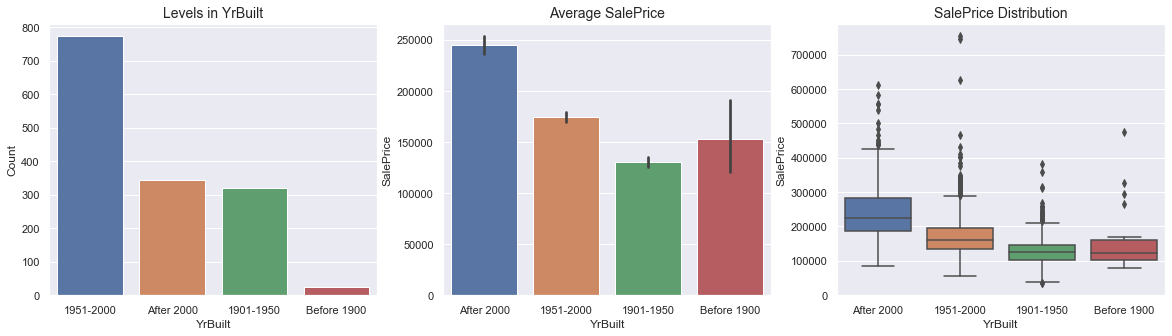

********************************************************************************


Variable       : YrRemodAdd
Levels         : 3

['1951-2000 (802)', 'After 2000 (476)', '1901-1950 (182)']

********************************************************************************



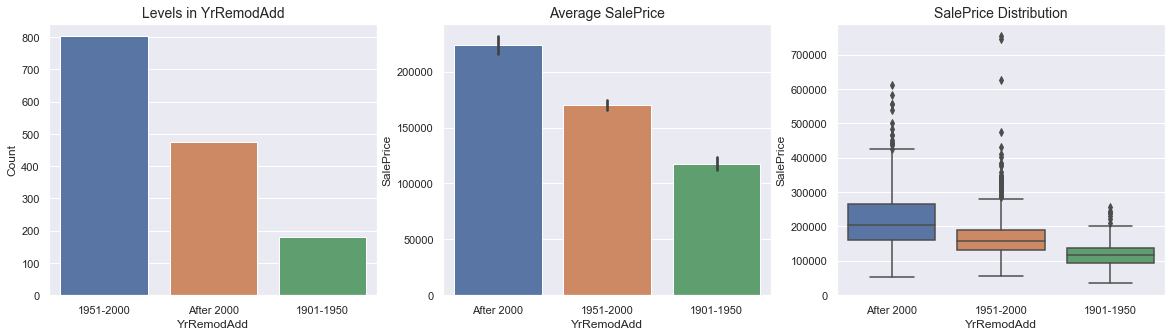

********************************************************************************


Variable       : YrGarageBlt
Levels         : 5

['1951-2000 (830)', 'After 2000 (355)', '1901-1950 (193)', 'nan (81)', 'Before 1900 (1)']

********************************************************************************



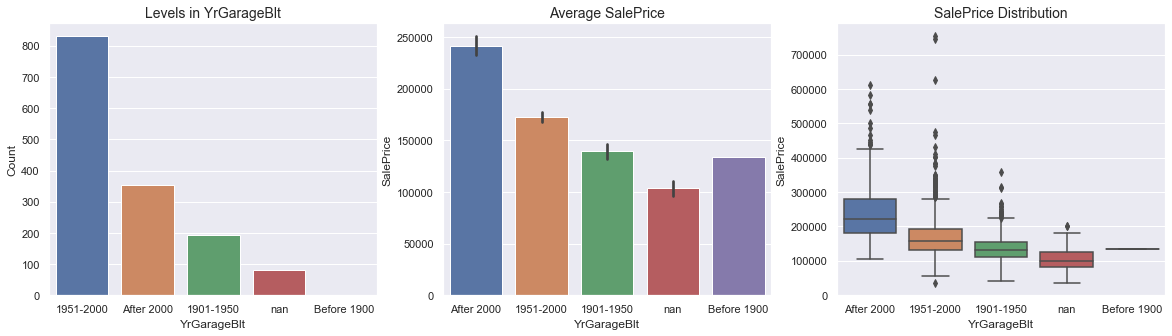

********************************************************************************



In [43]:
for column in years: visualize_categorical_variable(data = df, col = column, target = 'SalePrice')

In [44]:
# Years. We will convert all years into age with Year Sold as reference to get Numerical Discrete Values.

df['BuildingAge']  = df['YrSold'] - df['YearBuilt']
df['RemodeledAge'] = df['YrSold'] - df['YearRemodAdd']
df['GarageAge']    = df['YrSold'] - df['GarageYrBlt']

In [45]:
age = ['BuildingAge', 'RemodeledAge', 'GarageAge']

In [46]:
df[age].head()

BuildingAge  RemodeledAge  GarageAge
Id                                      
1             5             5        5.0
2            31            31       31.0
3             7             6        7.0
4            91            36        8.0
5             8             8        8.0

In [47]:
df.drop(columns = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrBuilt', 'YrRemodAdd', 'YrGarageBlt'], inplace = True)

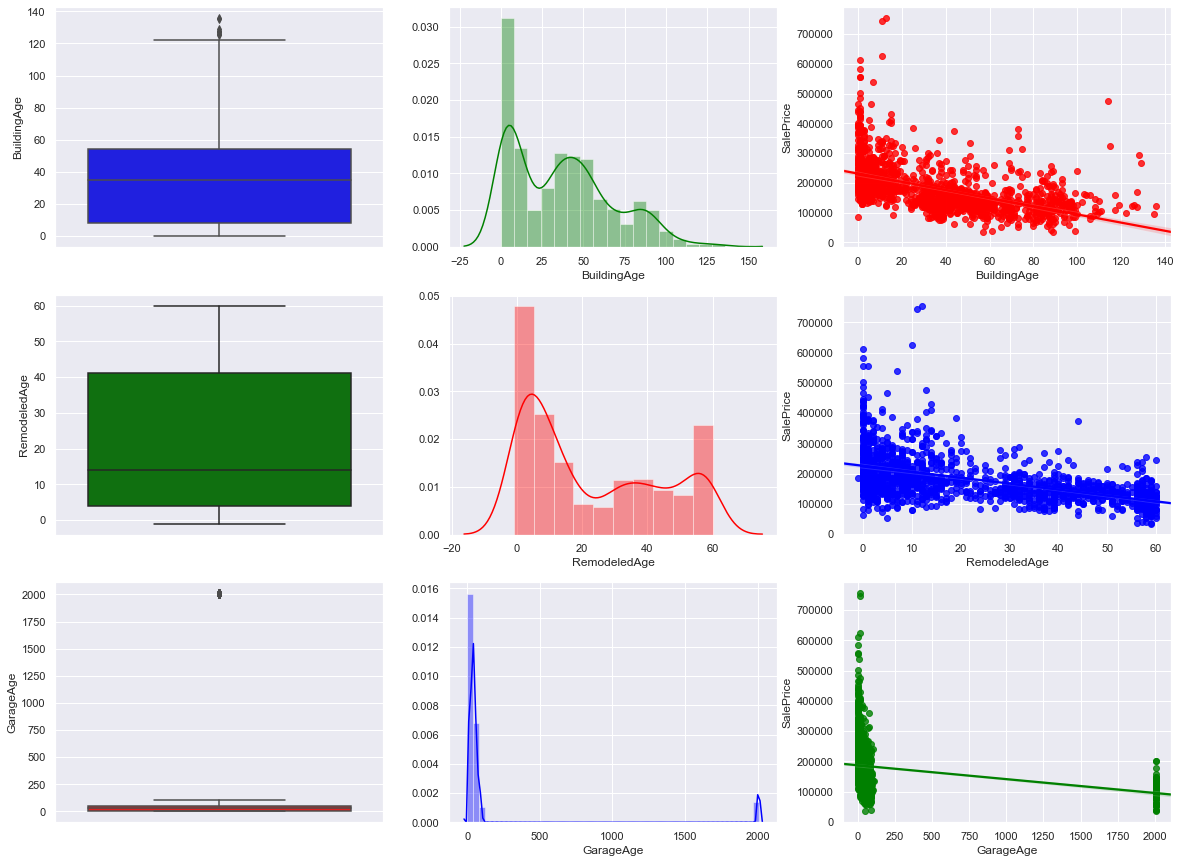

In [48]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

i = 0

palette = ['blue', 'green', 'red']

for column in age:
    
    sns.boxplot(data = df, y = column, ax = axes[i][0], color = palette[(i + 0) % 3])
    sns.distplot(df[column], hist = True, ax = axes[i][1], color = palette[(i + 1) % 3])
    sns.regplot(data = df, x = column, y = 'SalePrice', ax = axes[i][2], color = palette[(i + 2) % 3])
    
    i = i + 1
        
plt.show()

For most of the houses the garage is built in the recent years, but few of them had a garage built 2000 years ago. We see a trend of decrease in sale price with age of the building or the remodeling of the building.  

---

## 1.5. Capacity of the House and Its Impact

|Variable|Description| Data Type | Levels | Type of Data|
|:---|:---|:---|---:|:---|
|BsmtFullBath|Basement full bathrooms|int64|4|Categorical - Ordinal|
|BsmtHalfBath|Basement half bathrooms|int64|3|Categorical - Ordinal|
|FullBath|Full bathrooms above grade|int64|4|Categorical - Ordinal|
|HalfBath|Half baths above grade|int64|3|Categorical - Ordinal|
|BedroomAbvGr|Bedrooms above grade (does NOT include basement bedrooms)|int64|8|Categorical - Ordinal|
|KitchenAbvGr|Kitchens above grade|int64|4|Categorical - Ordinal|
|TotRmsAbvGrd|Total rooms above grade (does not include bathrooms)|int64|12|Categorical - Ordinal|
|Fireplaces|Number of fireplaces|int64|4|Categorical - Ordinal|
|GarageCars|Size of garage in car capacity|int64|5|Categorical - Ordinal|

In [49]:
%matplotlib inline

In [50]:
# These are variables that give the house capacity. Categorical variables expressed as discrete numeric values.

capacity = ['TotRmsAbvGrd', 
            'FullBath', 'HalfBath', 
            'BedroomAbvGr', 'KitchenAbvGr', 
            'BsmtFullBath', 'BsmtHalfBath', 
            'Fireplaces', 'GarageCars']

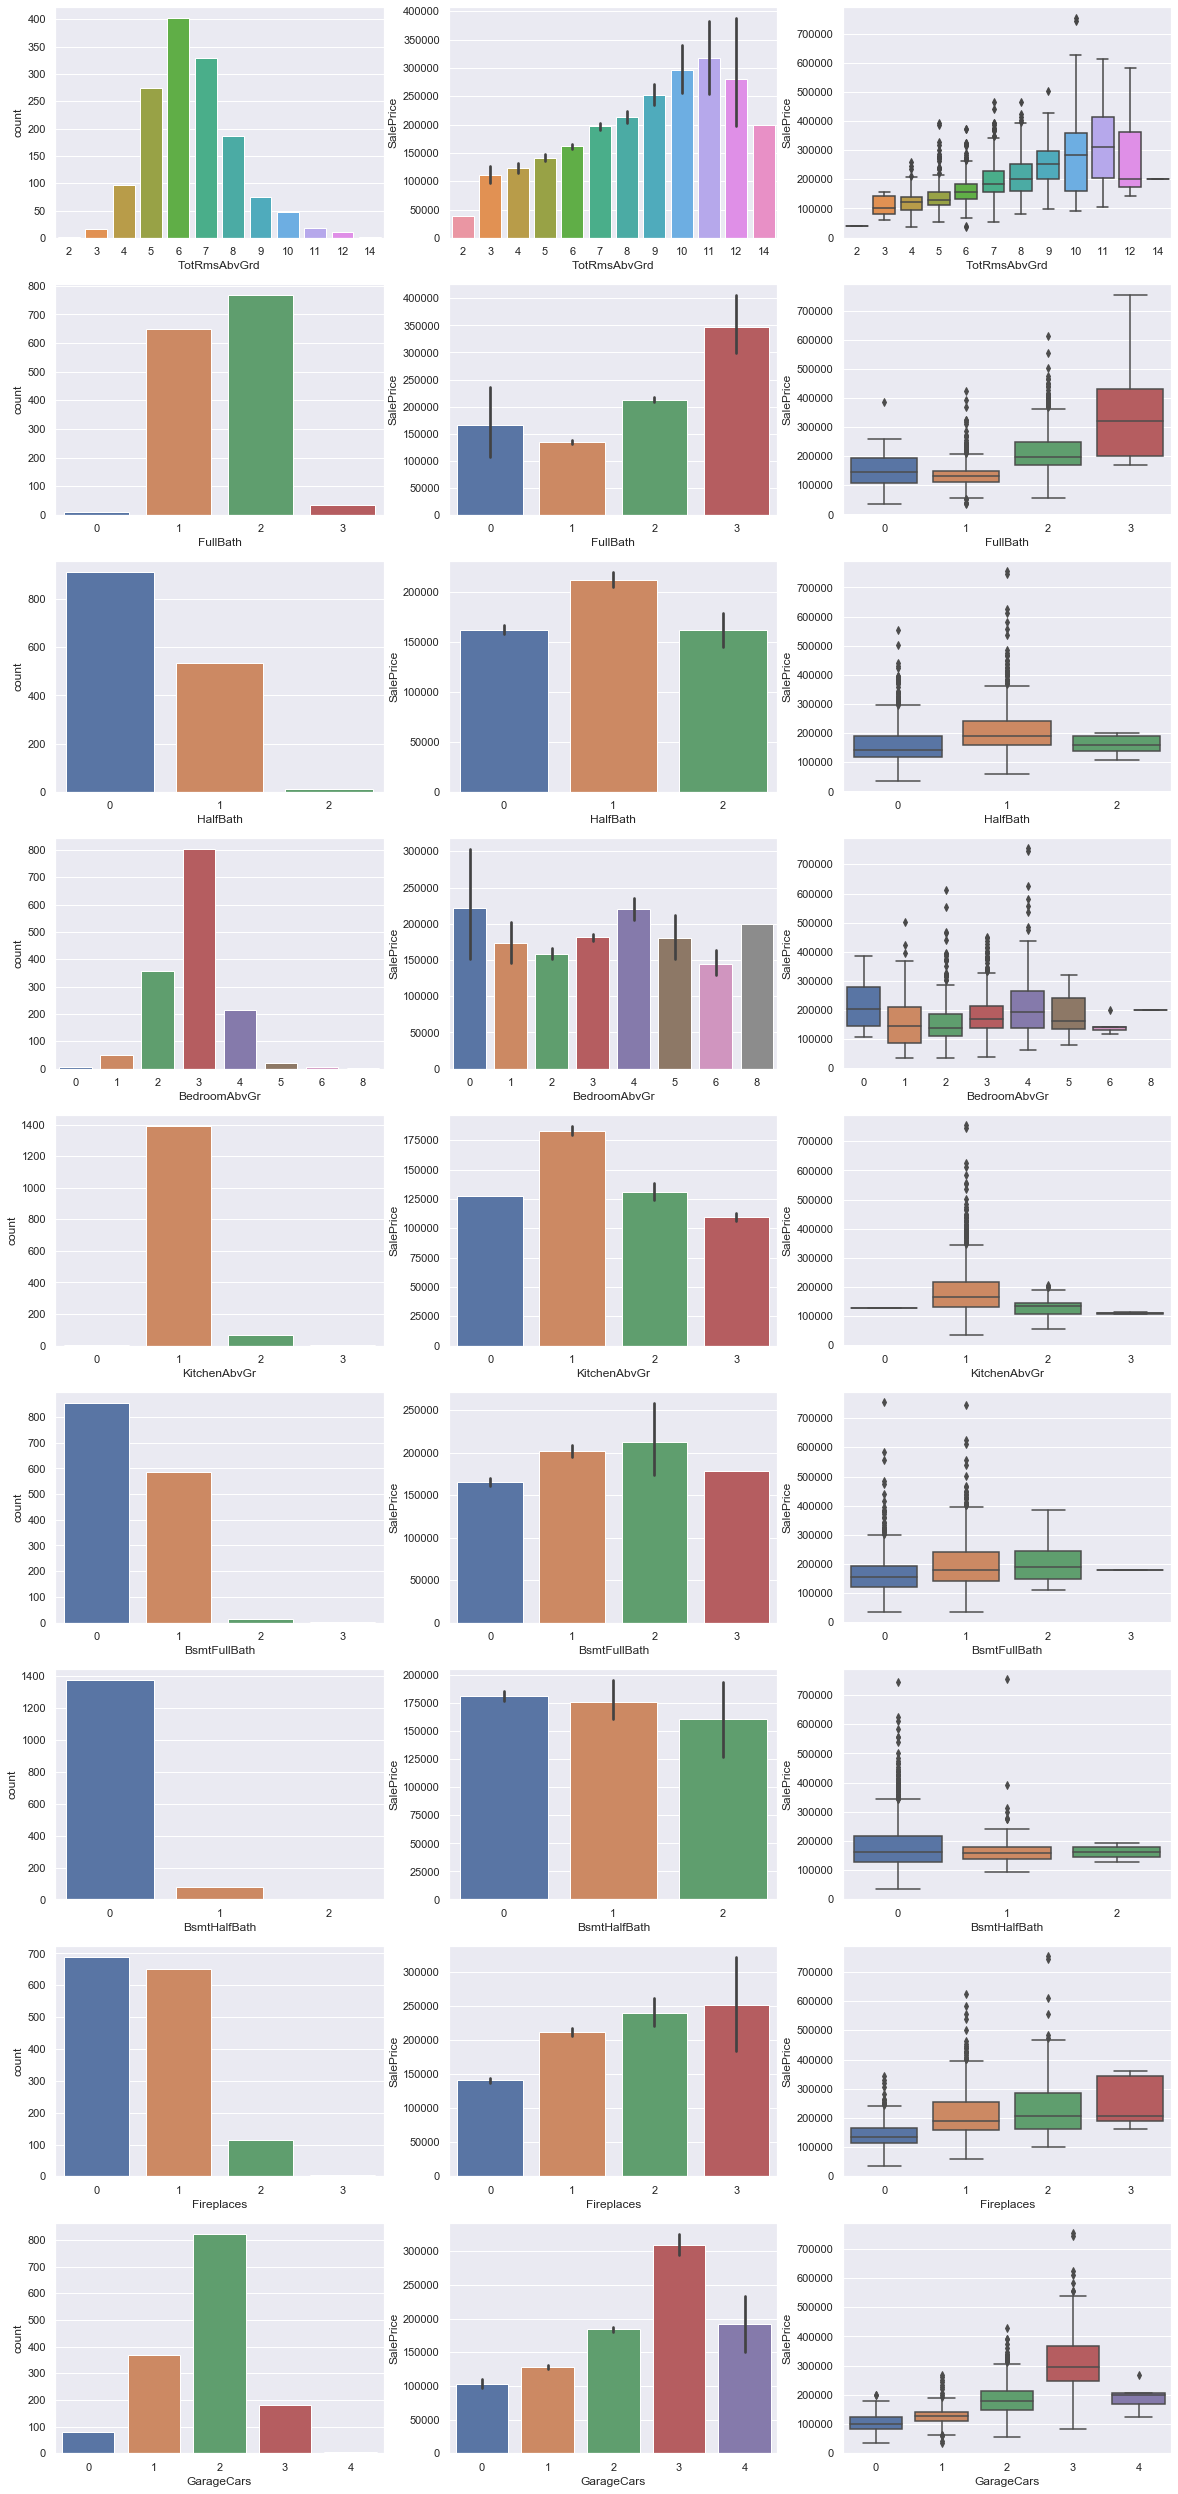

In [51]:
fig, axes = plt.subplots(9, 3, figsize=(20, 45))

i = 0

for col in capacity: 
    
    sns.countplot(data = df, x = col, ax = axes[i][0])
    sns.barplot(data = df, x = col, y = 'SalePrice', ax = axes[i][1])
    sns.boxplot(data = df, x = col, y = 'SalePrice', ax = axes[i][2])
    
    i = i + 1

plt.show()

---

## 1.6. Quality of the House and its Impact on Sale Price

|Variable|Description| Data Type | Levels | Type of Data|
|:---|:---|:---|---:|:---|
|OverallQual|Rates the overall material and finish of the house|int64|10|Categorical - Ordinal|
|OverallCond|Rates the overall condition of the house|int64|9|Categorical - Ordinal|
|ExterQual|Evaluates the quality of the material on the exterior|object|4|Categorical - Ordinal|
|ExterCond|Evaluates the present condition of the material on the exterior|object|5|Categorical - Ordinal|
|BsmtQual|Evaluates the height of the basement|object|4|Categorical - Ordinal|
|BsmtCond|Evaluates the general condition of the basement|object|4|Categorical - Ordinal|
|HeatingQC|Heating quality and condition|object|5|Categorical - Ordinal|
|KitchenQual|Kitchen quality|object|4|Categorical - Ordinal|
|FireplaceQu|Fireplace quality|object|5|Categorical - Ordinal|
|GarageQual|Garage quality|object|5|Categorical - Ordinal|
|GarageCond|Garage condition|object|5|Categorical - Ordinal|
|PoolQC|Pool quality|object|3|Categorical - Ordinal|  

In [52]:
%matplotlib inline

In [53]:
# These are variables that define the quality parameters. Categorical variables with ordinality.

quality = ['OverallQual', 'ExterQual', 'BsmtQual', 'GarageQual', 'KitchenQual', 
           'OverallCond', 'ExterCond', 'BsmtCond', 'GarageCond', 'HeatingQC', 'FireplaceQu']

### 1.6.1. Mapping the Quality Parameters to Numeric Values

In [54]:
df[quality].head()

OverallQual ExterQual BsmtQual GarageQual KitchenQual  OverallCond ExterCond BsmtCond GarageCond HeatingQC FireplaceQu
Id                                                                                                                        
1             7        Gd       Gd         TA          Gd            5        TA       TA         TA        Ex          NA
2             6        TA       Gd         TA          TA            8        TA       TA         TA        Ex          TA
3             7        Gd       Gd         TA          Gd            5        TA       TA         TA        Ex          TA
4             7        TA       TA         TA          Gd            5        TA       Gd         TA        Gd          Gd
5             8        Gd       Gd         TA          Gd            5        TA       TA         TA        Ex          TA

From data dictionary we understand that OverallQual and OverallCond has a rating scale from 1-10, whereas other features have five levels Excellent - EX, Good - GD, Average - TA, Fair - FA, Poor - PO, Not Applicable - NA. 

The following is the 10 point scale used: 10 - Very Excellent 9 - Excellent 8 - Very Good 7 - Good 6 - Above Average 5 - Average 4 - Below Average 3- Fair 2 - Poor 1 - Very Poor in OverallQual and OverallCond. 

We will map Ex (Excellent) to 9, Gd (Good) to 7, Average / Typical (TA) to 5, Fair (FA) to 3, Poor (Po) to  2 and 0 for Not Applicable. 

In [55]:
## The following columns need to be mapped.

mapcols = ['ExterQual', 'BsmtQual', 'KitchenQual', 
           'ExterCond', 'BsmtCond', 'GarageCond',
           'HeatingQC', 'FireplaceQu', 'GarageQual']

In [56]:
for column in mapcols: df[column] = df[column].map({'Ex': 9, 'Gd': 7, 'TA': 5, 'Fa': 3, 'Po': 2, 'NA': 0})

In [57]:
df[quality].head()

OverallQual  ExterQual  BsmtQual  GarageQual  KitchenQual  OverallCond  ExterCond  BsmtCond  GarageCond  HeatingQC  FireplaceQu
Id                                                                                                                                 
1             7          7         7           5            7            5          5         5           5          9            0
2             6          5         7           5            5            8          5         5           5          9            5
3             7          7         7           5            7            5          5         5           5          9            5
4             7          5         5           5            7            5          5         7           5          7            7
5             8          7         7           5            7            5          5         5           5          9            5

### 1.6.2. Visualizing the Impact of Quality of House

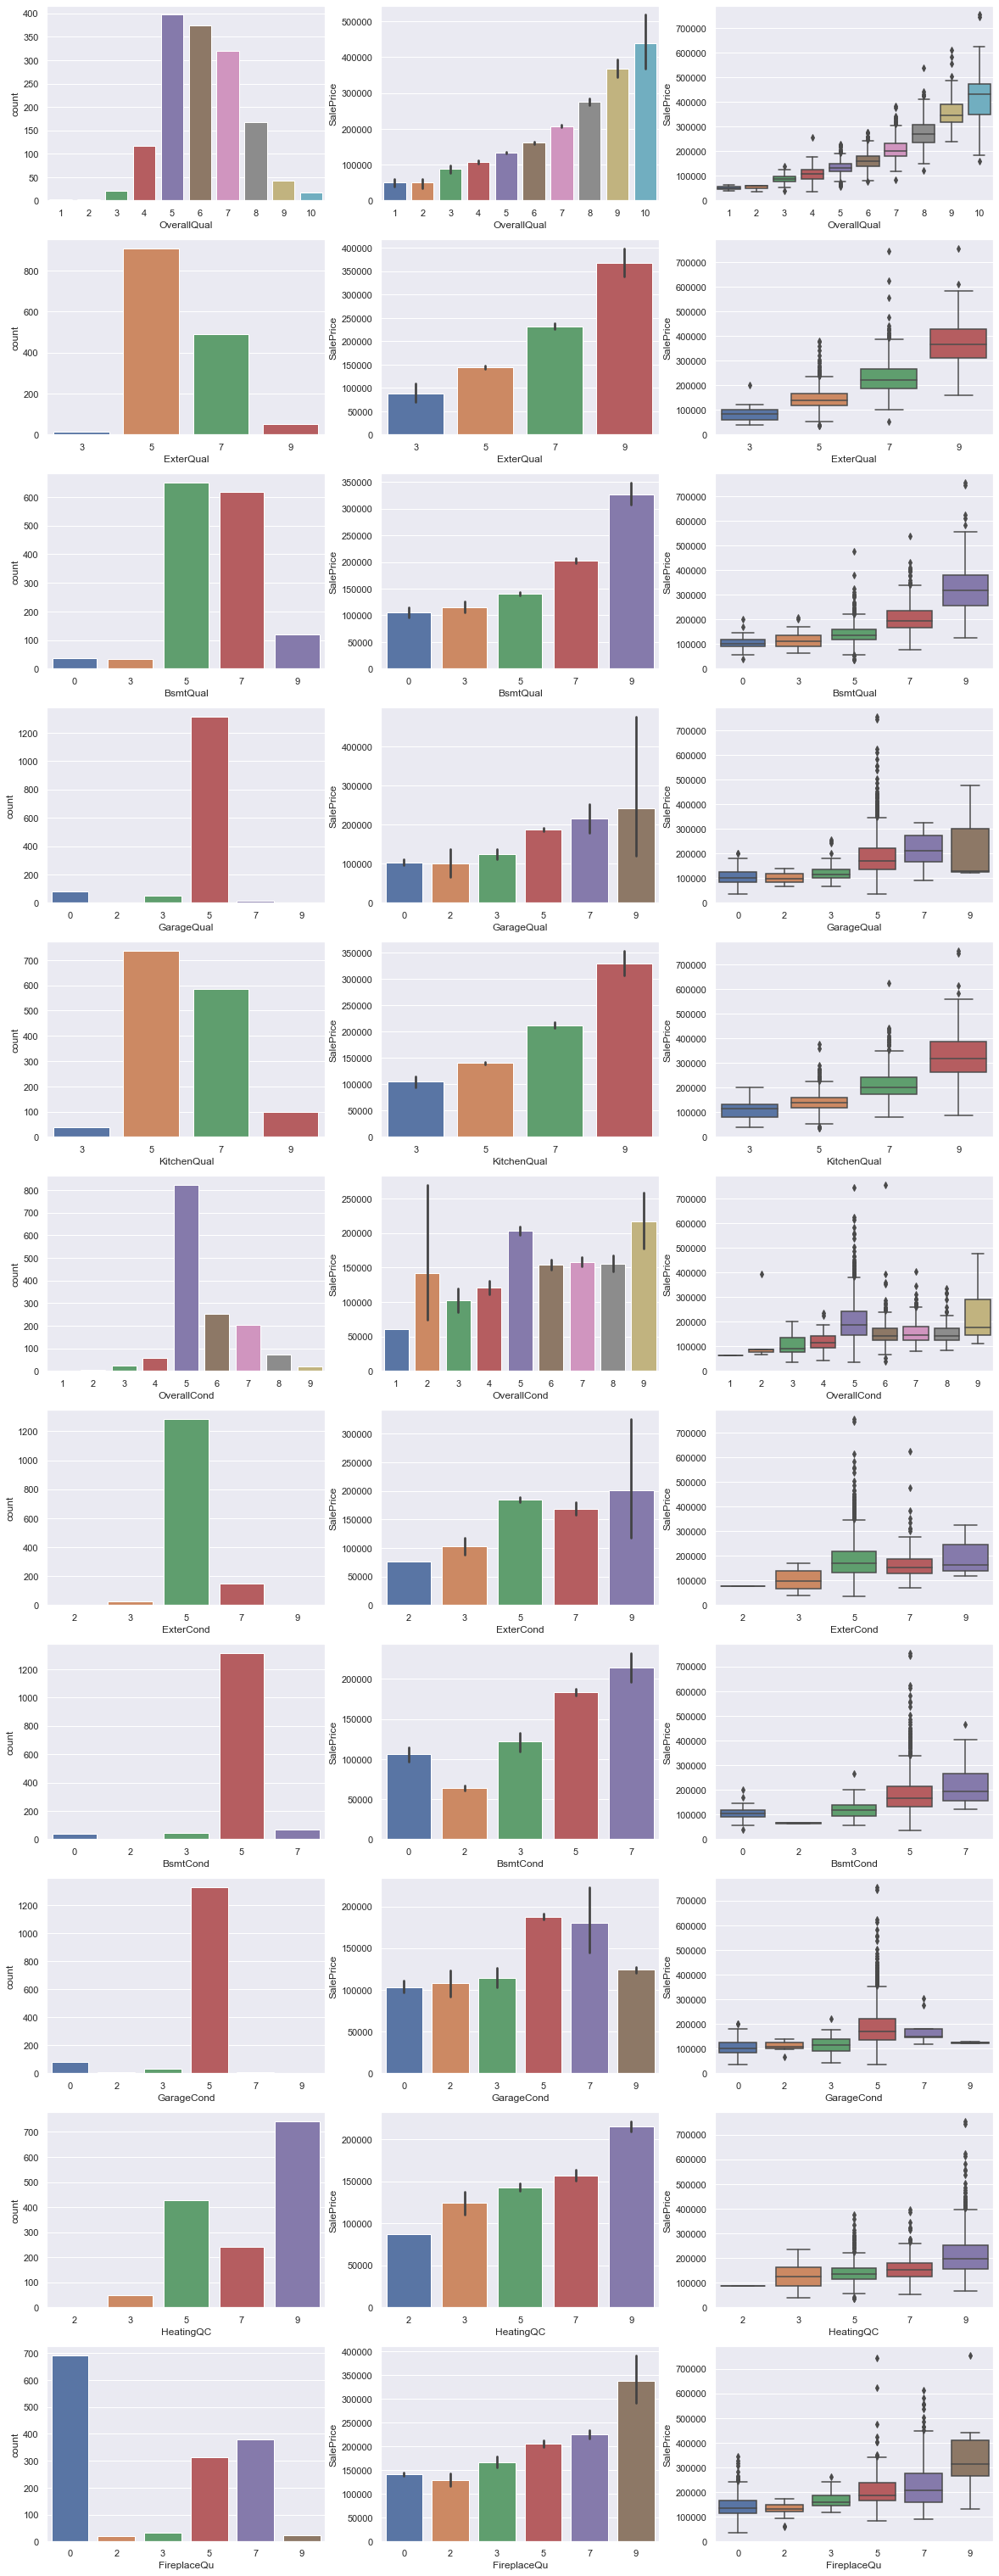

In [58]:
fig, axes = plt.subplots(11, 3, figsize=(20, 55))

i = 0

for col in quality: 
    
    sns.countplot(data = df, x = col, ax = axes[i][0])
    sns.barplot(data = df, x = col, y = 'SalePrice', ax = axes[i][1])
    sns.boxplot(data = df, x = col, y = 'SalePrice', ax = axes[i][2])
    
    i = i + 1

plt.show()

We see that better the quality, the price ranges are higher. We see the same trend with respect to the Basement Quality, Kitchen Quality, Garage Quality, and the quality of external material used. There are houses with basement, fireplace, or garage and this is indicated by 0. 

---

---

## 1.7. Numeric Variables in the Dataset

In [59]:
%matplotlib inline

In [60]:
# Most of the numeric variables give the house capacity in area.

numvar = ['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'WoodDeckSF', 'GarageArea', 'BsmtUnfSF', 
          'TotalBsmtSF', 'BsmtFinSF1', 'LotFrontage', 'LotArea', 'MasVnrArea', 'LowQualFinSF', 
          'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'BsmtFinSF2']

### 1.7.1. Distribution of Numeric Variables

In [61]:
df[numvar].describe(percentiles = [.10, .25, .5, .75, .85, .95, .99]).T

count          mean          std     min     10%      25%     50%       75%       85%       95%       99%       max
1stFlrSF       1460.0   1162.626712   386.587738   334.0   756.9   882.00  1087.0   1391.25   1572.15   1831.25   2219.46    4692.0
2ndFlrSF       1460.0    346.992466   436.528436     0.0     0.0     0.00     0.0    728.00    870.15   1141.05   1418.92    2065.0
GrLivArea      1460.0   1515.463699   525.480383   334.0   912.0  1129.50  1464.0   1776.75   1987.30   2466.10   3123.48    5642.0
WoodDeckSF     1460.0     94.244521   125.338794     0.0     0.0     0.00     0.0    168.00    216.00    335.00    505.46     857.0
GarageArea     1460.0    472.980137   213.804841     0.0   240.0   334.50   480.0    576.00    672.00    850.10   1002.79    1418.0
BsmtUnfSF      1460.0    567.240411   441.866955     0.0    74.9   223.00   477.5    808.00   1010.30   1468.00   1797.05    2336.0
TotalBsmtSF    1460.0   1057.429452   438.705324     0.0   636.9   795.75   991.5   1298.25   1485.15   1753.00   2155.05    6110.0
BsmtFinSF1     1460.0    443.639726   456.098091     0.0     0.0     0.00   383.5    712.25    929.45   1274.00   1572.41    5644.0
LotFrontage    1460.0     57.623288    34.664304     0.0     0.0    42.00    63.0     79.00     85.00    104.00    137.41     313.0
LotArea        1460.0  10516.828082  9981.264932  1300.0  5000.0  7553.50  9478.5  11601.50  13161.10  17401.15  37567.64  215245.0
MasVnrArea     1460.0    103.117123   180.731373     0.0     0.0     0.00     0.0    164.25    261.15    456.00    791.28    1600.0
LowQualFinSF   1460.0      5.844521    48.623081     0.0     0.0     0.00     0.0      0.00      0.00      0.00    360.00     572.0
OpenPorchSF    1460.0     46.660274    66.256028     0.0     0.0     0.00    25.0     68.00    105.00    175.05    285.82     547.0
EnclosedPorch  1460.0     21.954110    61.119149     0.0     0.0     0.00     0.0      0.00      0.00    180.15    261.05     552.0
3SsnPorch      1460.0      3.409589    29.317331     0.0     0.0     0.00     0.0      0.00      0.00      0.00    168.00     508.0
ScreenPorch    1460.0     15.060959    55.757415     0.0     0.0     0.00     0.0      0.00      0.00    160.00    268.05     480.0
PoolArea       1460.0      2.758904    40.177307     0.0     0.0     0.00     0.0      0.00      0.00      0.00      0.00     738.0
BsmtFinSF2     1460.0     46.549315   161.319273     0.0     0.0     0.00     0.0      0.00      0.00    396.20    830.38    1474.0

In [62]:
palette = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

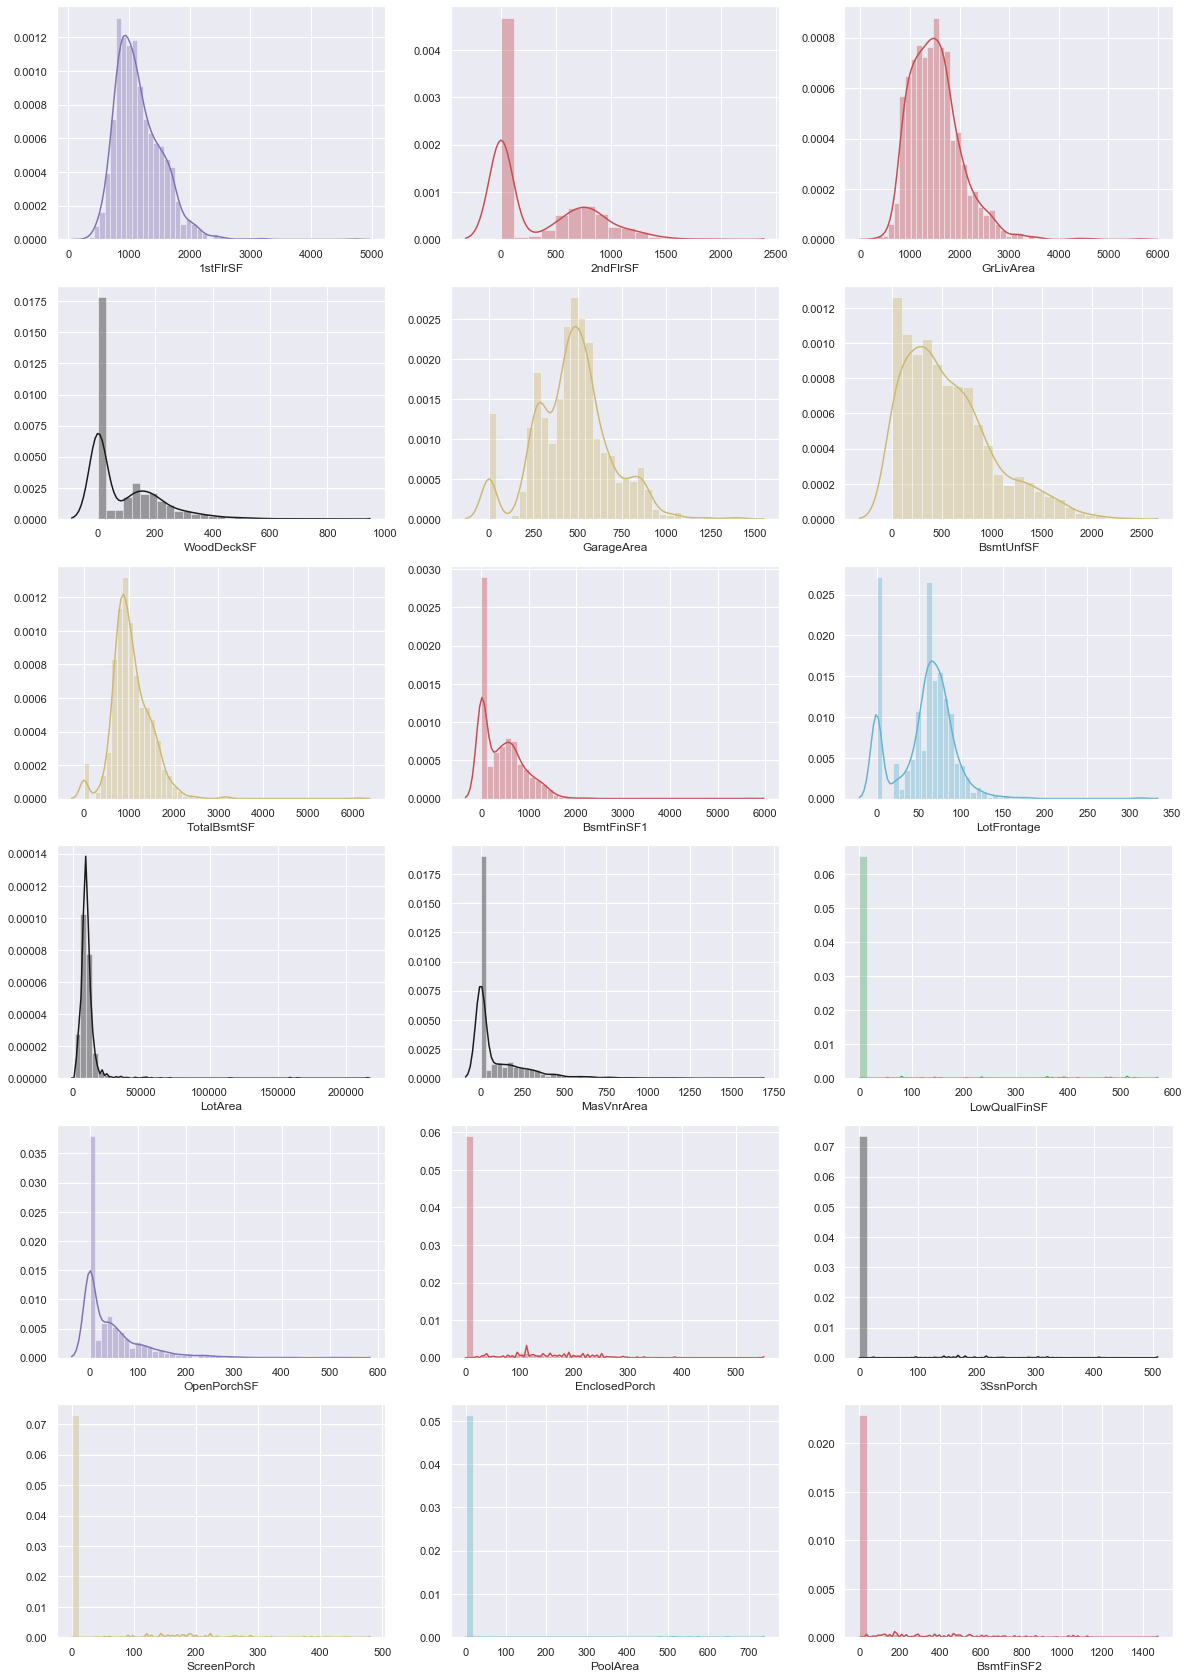

In [63]:
fig, axes = plt.subplots(6, 3, figsize=(20, 30))

i = 0; j = 0

for column in numvar:     
    c = (rd.randrange(0, 100) + i + j) % 7
    sns.distplot(df[column], hist = True, ax = axes[i][j], color = palette[c])
    j = j + 1
    if j > 2: j = 0; i = i + 1
        
plt.show()

There is lot of concentration around the value 0 in some of the variables. PoolArea of 0 indicates there is no pool. Similarly we see in Basement, Porch etc.

### 1.7.2. Studying the Outliers

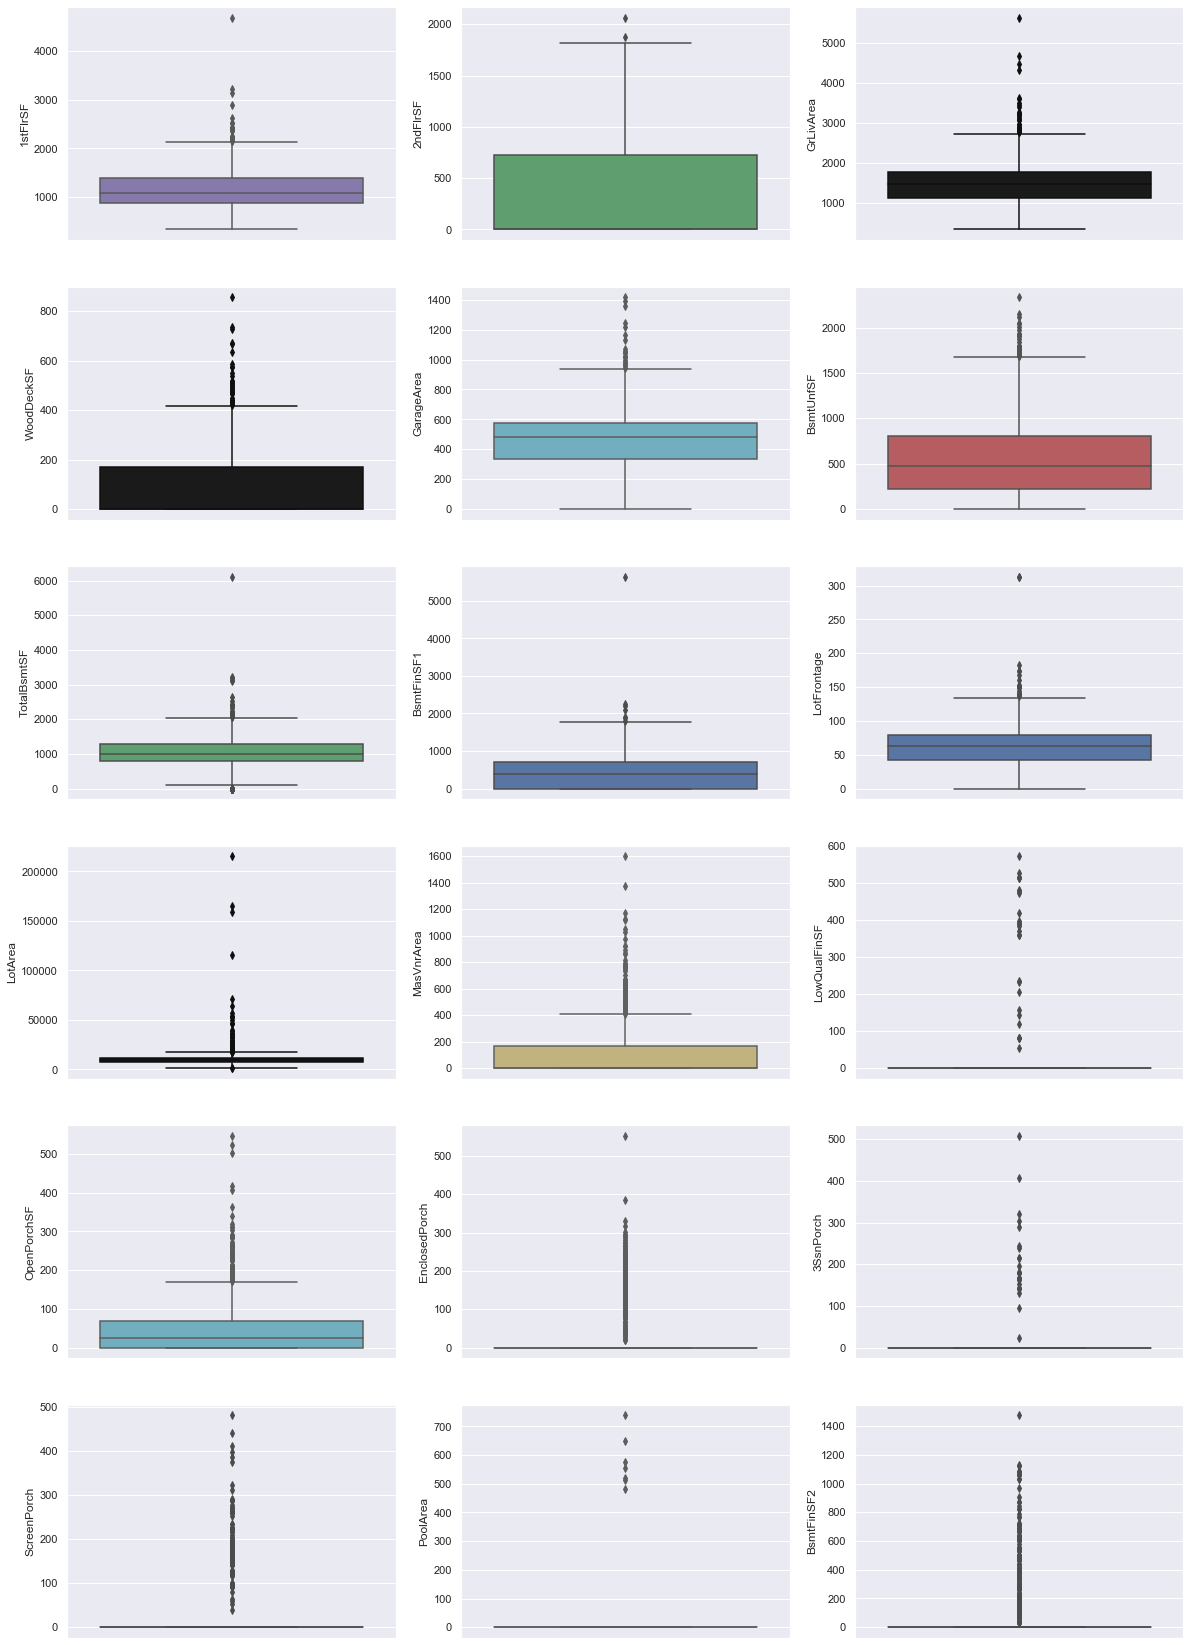

In [64]:
fig, axes = plt.subplots(6, 3, figsize=(20, 30))

i = 0; j = 0

for column in numvar:     
    c = (rd.randrange(0, 100) + i * 10 + j * 10) % 7
    sns.boxplot(data = df, y = column, ax = axes[i][j], color = palette[c])
    j = j + 1
    if j > 2: j = 0; i = i + 1
        
plt.show()

The numerical variables give the area of the house. We see a lot of outliers. With respect to input variables, it is better to treat them as influencers than calling them outliers. These extra features may influence the price of the house. Let us plot scatter plots to see their influence on the house price.

### 1.7.3. Bivariate - Scatter Plot against Target Variable

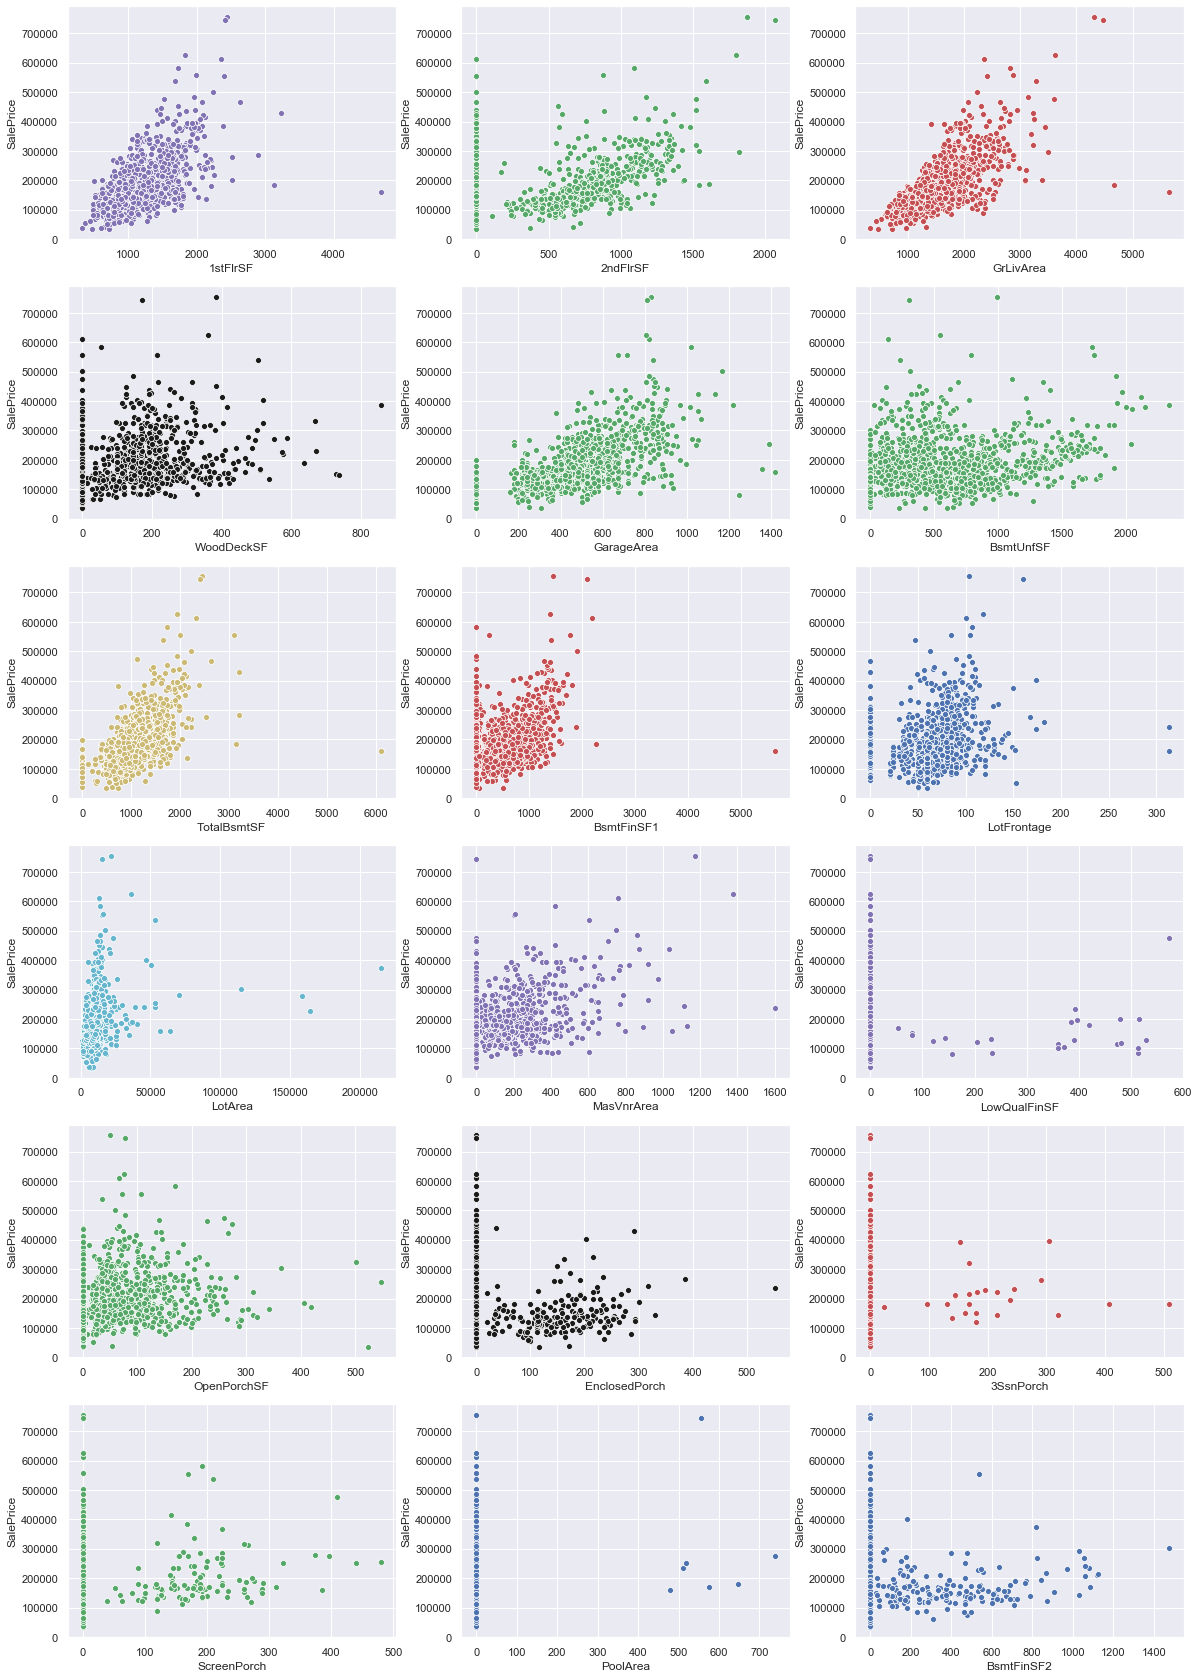

In [65]:
fig, axes = plt.subplots(6, 3, figsize=(20, 30))

i = 0; j = 0

for column in numvar:     
    c = (rd.randrange(0, 100) + i * 10 + j * 10) % 7
    sns.scatterplot(data = df, x = column, y = 'SalePrice', ax = axes[i][j], color = palette[c])
    j = j + 1
    if j > 2: j = 0; i = i + 1
        
plt.show()

### 1.7.4. Correlation between Numeric Variables

In [66]:
corrvar = ['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'WoodDeckSF', 'GarageArea', 
           'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFinSF1', 'LotFrontage', 'LotArea', 
           'MasVnrArea', 'LowQualFinSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
           'ScreenPorch', 'PoolArea', 'BsmtFinSF2', 'MiscVal', 'SalePrice', 'SalePriceLog']

In [67]:
correlation = df[corrvar].corr()

(21.0, 0.0)

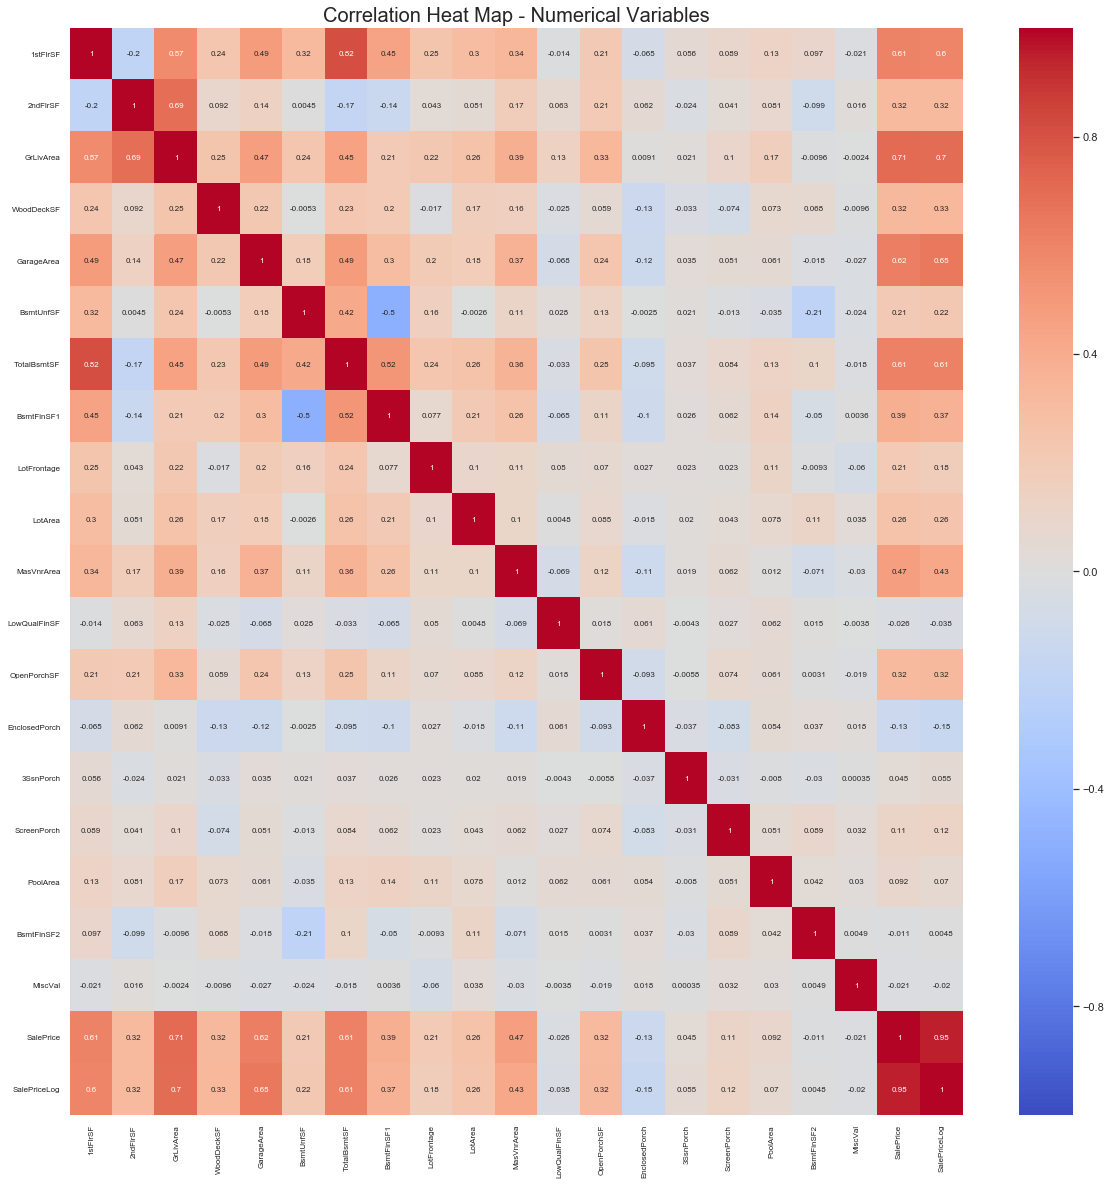

In [68]:
# plot correlation heat map for numeric variables

f, ax = plt.subplots(figsize=(20, 20))

heatmap = sns.heatmap(correlation, vmin = -1, vmax = 1, cmap = "coolwarm", annot = True, annot_kws = {"size": 8})

heatmap.set_yticklabels(heatmap.get_yticklabels(), size = 8)
heatmap.set_xticklabels(heatmap.get_xticklabels(), size = 8)

# add title to the plot
ax.set_title('Correlation Heat Map - Numerical Variables', fontsize = 20)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

# due to a bug in seaborn the first and last row square are getting cut in half - the following code fixes it
bottom, top = ax.get_ylim(); ax.set_ylim(bottom + 0.5, top - 0.5)

We see some strong correlation between some of the area values and the sale price. There is a strong correlation among some of the price influencers also.

---

## 1.8. Other Categorical Variables

In [69]:
# All the remaining categorical variables

catvar = ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
          'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
          'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
          'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive']

The remaining catevorical variables describe the house in various ways.

|Variable|Description|Data Type|Levels|Type of Variable|
|:---|:---|:---|:---|:---|
|MSSubClass|Identifies the type of dwelling involved in the sale.|int64|15|Categorical - Nominal|
|MSZoning|Identifies the general zoning classification of the sale.|object|5|Categorical - Nominal|
|Street|Type of road access to property|object|2|Categorical - Nominal|
|LotShape|General shape of property|object|4|Categorical - Nominal|
|LandContour|Flatness of the property|object|4|Categorical - Nominal|
|Utilities|Type of utilities available|object|2|Categorical - Nominal|
|LotConfig|Lot configuration|object|5|Categorical - Nominal|
|LandSlope|Slope of property|object|3|Categorical - Nominal|
|Neighborhood|Physical locations within Ames city limits|object|25|Categorical - Nominal|
|Condition1|Proximity to various conditions|object|9|Categorical - Nominal|
|Condition2|Proximity to various conditions (if more than one is present)|object|8|Categorical - Nominal|
|BldgType|Type of dwelling|object|5|Categorical - Nominal|
|HouseStyle|Style of dwelling|object|8|Categorical - Nominal|
|RoofStyle|Type of roof|object|6|Categorical - Nominal|
|RoofMatl|Roof material|object|8|Categorical - Nominal|
|Exterior1st|Exterior covering on house|object|15|Categorical - Nominal|
|Exterior2nd|Exterior covering on house (if more than one material)|object|16|Categorical - Nominal|
|MasVnrType|Masonry veneer type|object|4|Categorical - Nominal|
|Foundation|Type of foundation|object|6|Categorical - Nominal|
|BsmtExposure|Refers to walkout or garden level walls|object|4|Categorical - Nominal|
|BsmtFinType1|Rating of basement finished area|object|6|Categorical - Nominal|
|BsmtFinType2|Rating of basement finished area (if multiple types)|object|6|Categorical - Nominal|
|Heating|Type of heating|object|6|Categorical - Nominal|
|CentralAir|Central air conditioning|object|2|Categorical - Nominal|
|Electrical|Electrical system|object|5|Categorical - Nominal|
|Functional|Home functionality (Assume typical unless deductions are warranted)|object|7|Categorical - Nominal|
|GarageType|Garage location|object|6|Categorical - Nominal|
|GarageFinish|Interior finish of the garage|object|3|Categorical - Nominal|
|PavedDrive|Paved driveway|object|3|Categorical - Nominal|

### 1.8.1. Categorical Variables on Selling 

In [70]:
%matplotlib inline

In [71]:
sales = ['SaleType', 'SaleCondition', 'YrSold', 'MoSold']


Variable       : SaleType
Levels         : 9

['WD (1267)', 'New (122)', 'COD (43)', 'ConLD (9)', 'ConLI (5)', 'ConLw (5)', 'CWD (4)', 'Oth (3)', 'Con (2)']

********************************************************************************



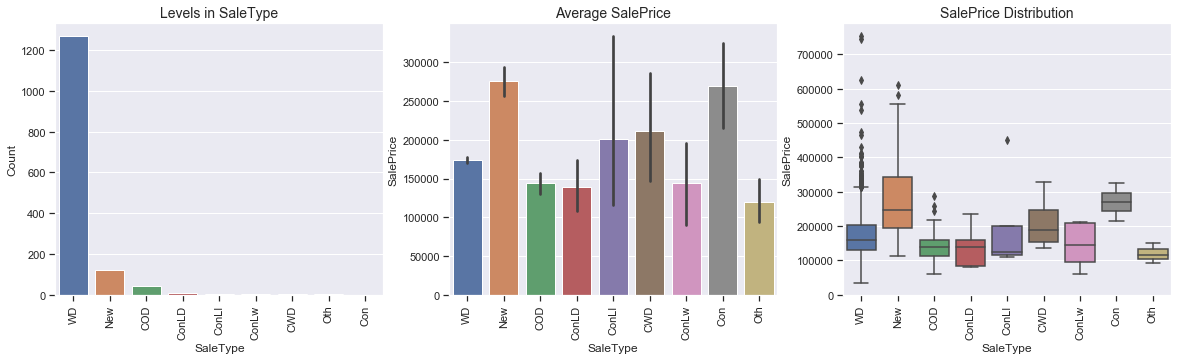

********************************************************************************


Variable       : SaleCondition
Levels         : 6

['Normal (1198)', 'Partial (125)', 'Abnorml (101)', 'Family (20)', 'Alloca (12)', 'AdjLand (4)']

********************************************************************************



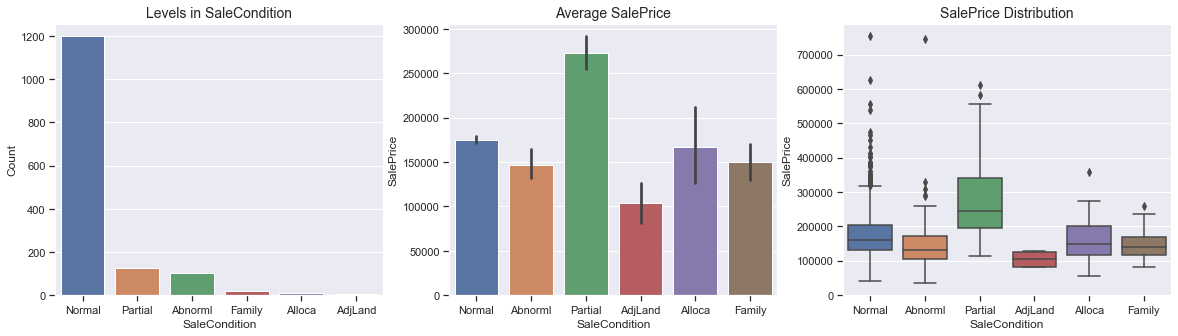

********************************************************************************


Variable       : YrSold
Levels         : 5

['2009 (338)', '2007 (329)', '2006 (314)', '2008 (304)', '2010 (175)']

********************************************************************************



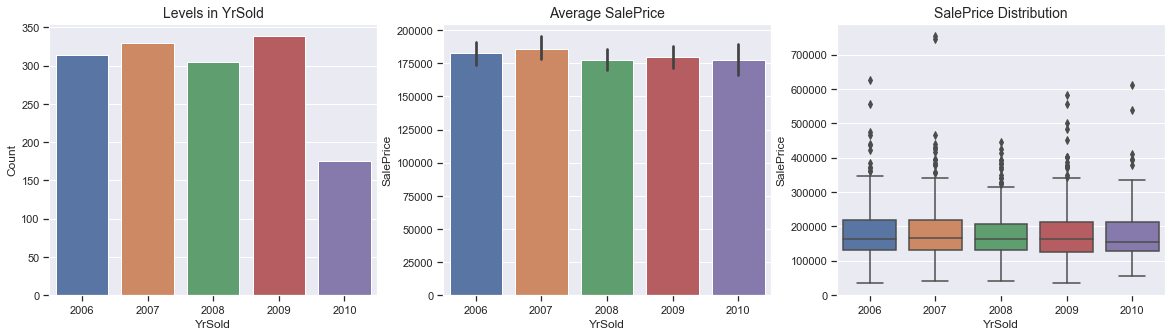

********************************************************************************


Variable       : MoSold
Levels         : 12

['6 (253)', '7 (234)', '5 (204)', '4 (141)', '8 (122)', '3 (106)', '10 (89)', '11 (79)', '9 (63)', '12 (59)', '1 (58)', '2 (52)']

********************************************************************************



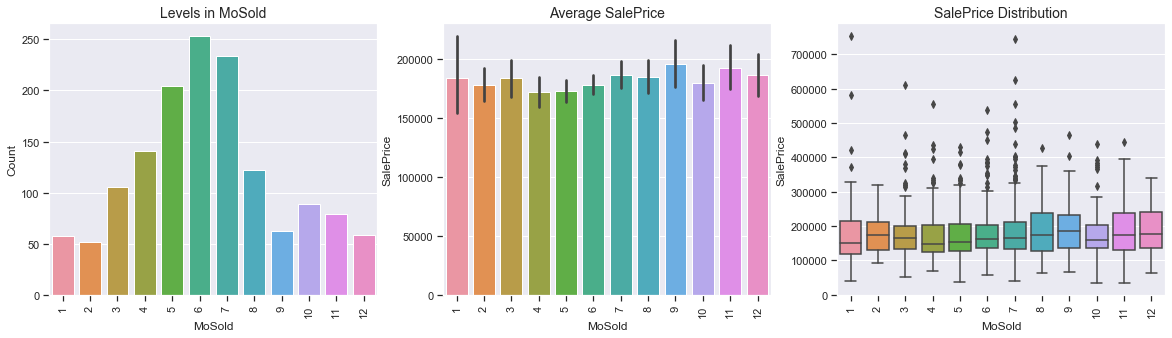

********************************************************************************



In [72]:
for column in sales: visualize_categorical_variable(data = df, col = column, target = 'SalePrice')

The average price of the house sold does not vary much with the year or month. However, we see that the number of houses sold are peaking towards the mid of the year and much lesser in the begining and end. 87% of the houses were sold on conventional warranty deed (WD) and for 82% of the samples the sale type is Normal. These variables may not contribute much to the final model.

In [73]:
# Mapping years to numeric values

df['YrSold'] = df['YrSold'].map({2006: 6, 2007: 7, 2008: 8, 2009: 9, 2010: 10})

### 1.8.2. Dealing with Skewed Categorical Variables

The following variables can be dropped due to the skewness, lack of variability, and lack of serious influence on the SalePrice variable.

 - __Street__ has 2 levels. 1454 records with Pave and 6 records with Grvl. 
 - __Utilities__ has 2 levels. 1459 records with AllPub and onlly one records with NoSeWa. 
 - __LandSlope__ has 3 levels. 1382 records with Gtl (Gentle Slope), 65 records with Mod (Moderate Slope) and 13 records with Sev (Severe Slope). 94% of the houses have a Gentle Slope. 
 - __Condition2__ has 8 levels, but 1445 records (i.e. 99%) has the value Norm. 
 - __RoofMatl__ has 8 levels. 1434 records (98%) have the value CompShg stands for Standard (Composite) Shingle. 
 - __Heating__ has 6 levels. The value distribution is skewed with 1428 records having GasA (97.8%) and the remaining records have 5 different values. 

In [74]:
skewed = ['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'Heating']


Variable       : Street
Levels         : 2

['Pave (1454)', 'Grvl (6)']

********************************************************************************



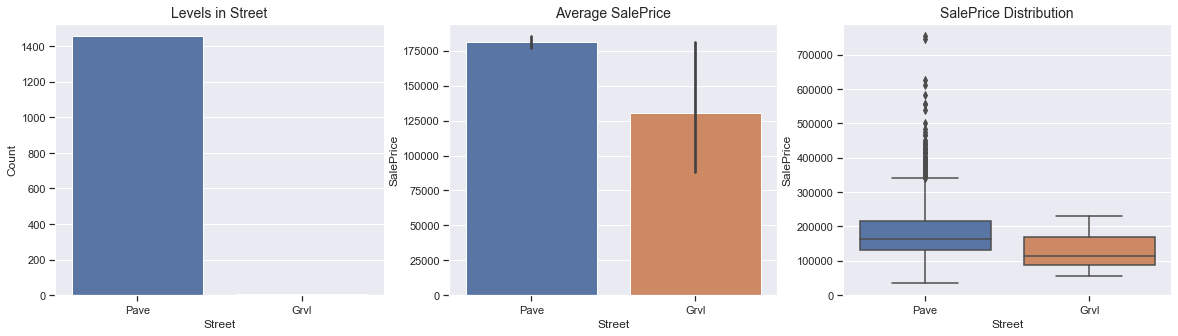

********************************************************************************


Variable       : Utilities
Levels         : 2

['AllPub (1459)', 'NoSeWa (1)']

********************************************************************************



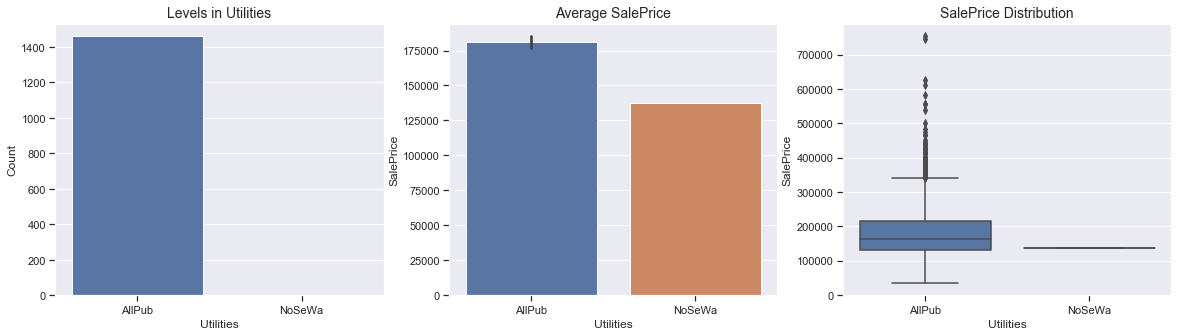

********************************************************************************


Variable       : LandSlope
Levels         : 3

['Gtl (1382)', 'Mod (65)', 'Sev (13)']

********************************************************************************



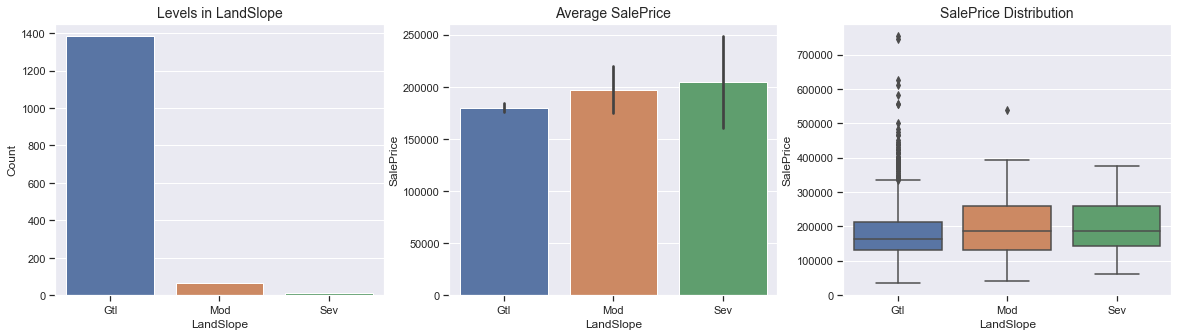

********************************************************************************


Variable       : Condition2
Levels         : 8

['Norm (1445)', 'Feedr (6)', 'RRNn (2)', 'PosN (2)', 'Artery (2)', 'RRAn (1)', 'RRAe (1)', 'PosA (1)']

********************************************************************************



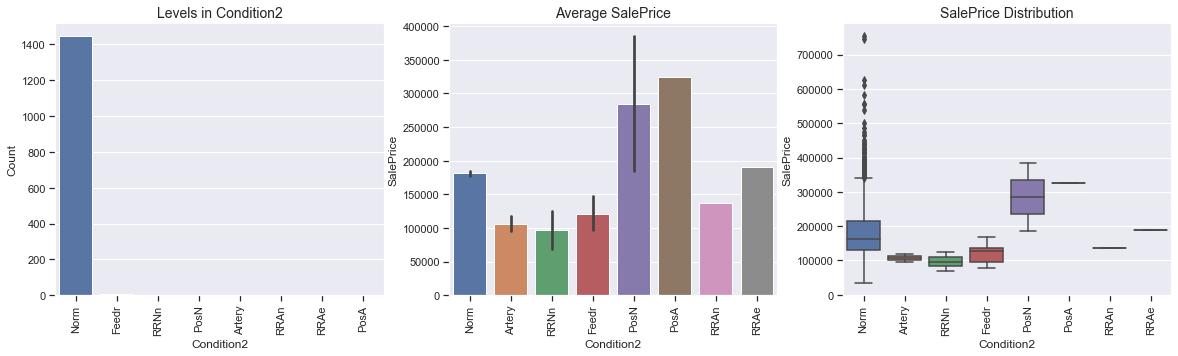

********************************************************************************


Variable       : RoofMatl
Levels         : 8

['CompShg (1434)', 'Tar&Grv (11)', 'WdShngl (6)', 'WdShake (5)', 'Metal (1)', 'ClyTile (1)', 'Roll (1)', 'Membran (1)']

********************************************************************************



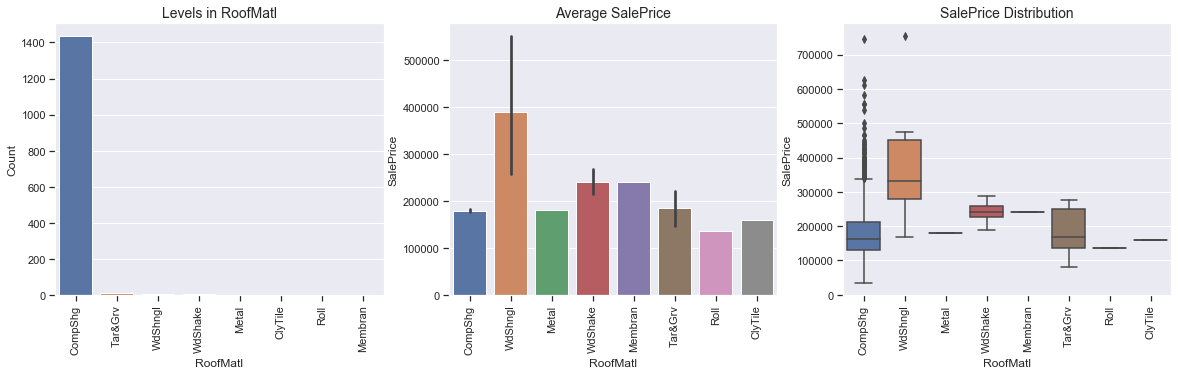

********************************************************************************


Variable       : Heating
Levels         : 6

['GasA (1428)', 'GasW (18)', 'Grav (7)', 'Wall (4)', 'OthW (2)', 'Floor (1)']

********************************************************************************



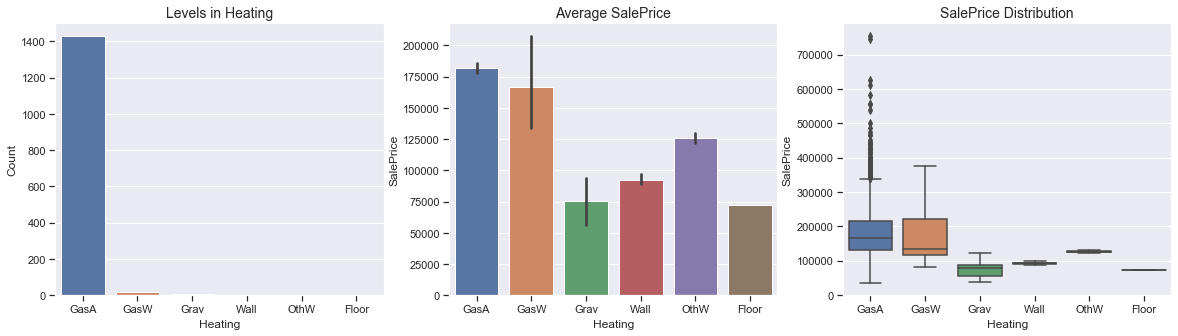

********************************************************************************



In [75]:
for column in skewed: visualize_categorical_variable(data = df, col = column, target = 'SalePrice')

In [76]:
# dropping the categorical columns that are skewed

df.drop(columns = skewed, inplace = True)

### 1.8.3. Visualizing the Other Categorical Variables

In [77]:
others = ['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 
          'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 
          'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
          'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive']


Variable       : MSSubClass
Levels         : 15

['20 (536)', '60 (299)', '50 (144)', '120 (87)', '30 (69)', '160 (63)', '70 (60)', '80 (58)', '90 (52)', '190 (30)', '85 (20)', '75 (16)', '45 (12)', '180 (10)', '40 (4)']

********************************************************************************



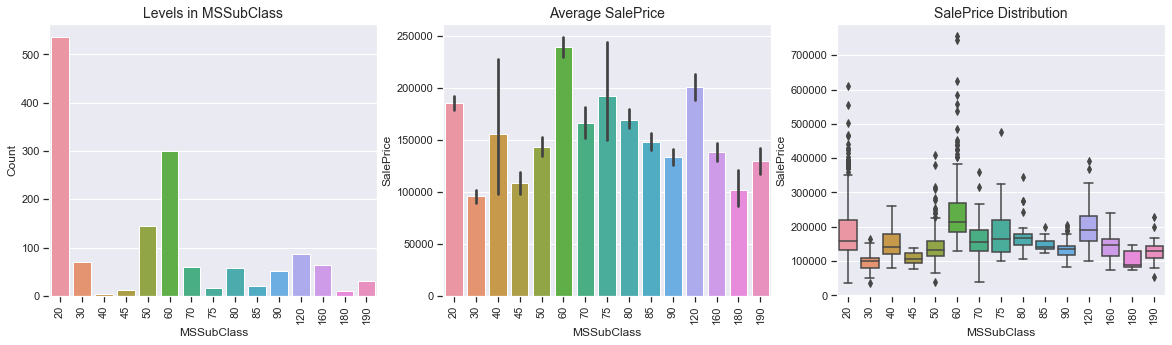

********************************************************************************


Variable       : MSZoning
Levels         : 5

['RL (1151)', 'RM (218)', 'FV (65)', 'RH (16)', 'C (all) (10)']

********************************************************************************



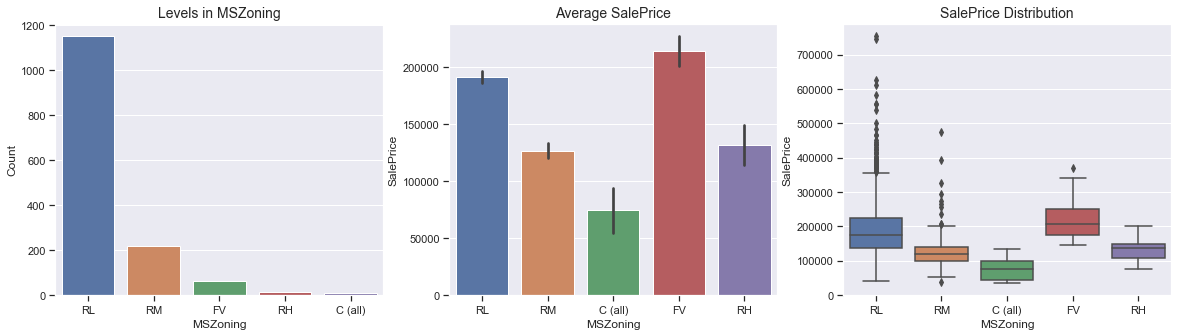

********************************************************************************


Variable       : LotShape
Levels         : 4

['Reg (925)', 'IR1 (484)', 'IR2 (41)', 'IR3 (10)']

********************************************************************************



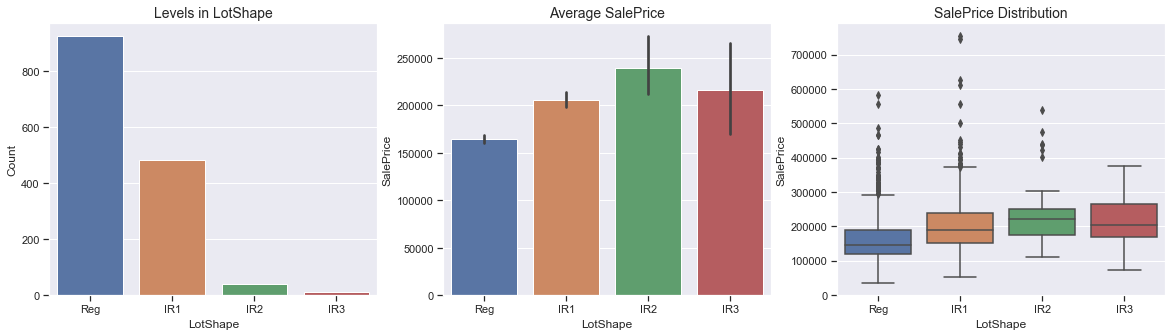

********************************************************************************


Variable       : LandContour
Levels         : 4

['Lvl (1311)', 'Bnk (63)', 'HLS (50)', 'Low (36)']

********************************************************************************



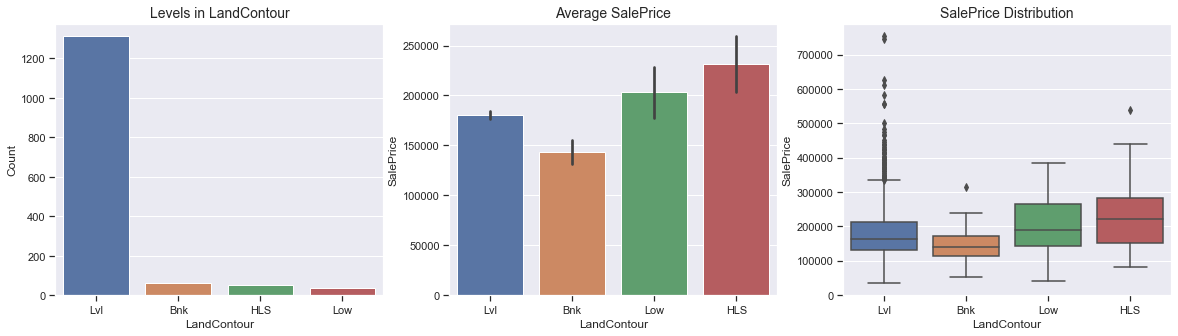

********************************************************************************


Variable       : LotConfig
Levels         : 5

['Inside (1052)', 'Corner (263)', 'CulDSac (94)', 'FR2 (47)', 'FR3 (4)']

********************************************************************************



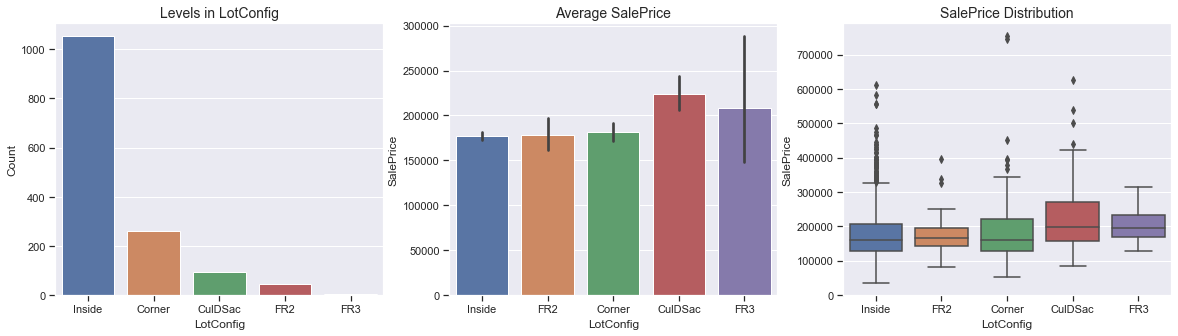

********************************************************************************


Variable       : Neighborhood
Levels         : 25

['NAmes (225)', 'CollgCr (150)', 'OldTown (113)', 'Edwards (100)', 'Somerst (86)', 'Gilbert (79)', 'NridgHt (77)', 'Sawyer (74)', 'NWAmes (73)', 'SawyerW (59)', 'BrkSide (58)', 'Crawfor (51)', 'Mitchel (49)', 'NoRidge (41)', 'Timber (38)', 'IDOTRR (37)', 'ClearCr (28)', 'SWISU (25)', 'StoneBr (25)', 'Blmngtn (17)', 'MeadowV (17)', 'BrDale (16)', 'Veenker (11)', 'NPkVill (9)', 'Blueste (2)']

********************************************************************************



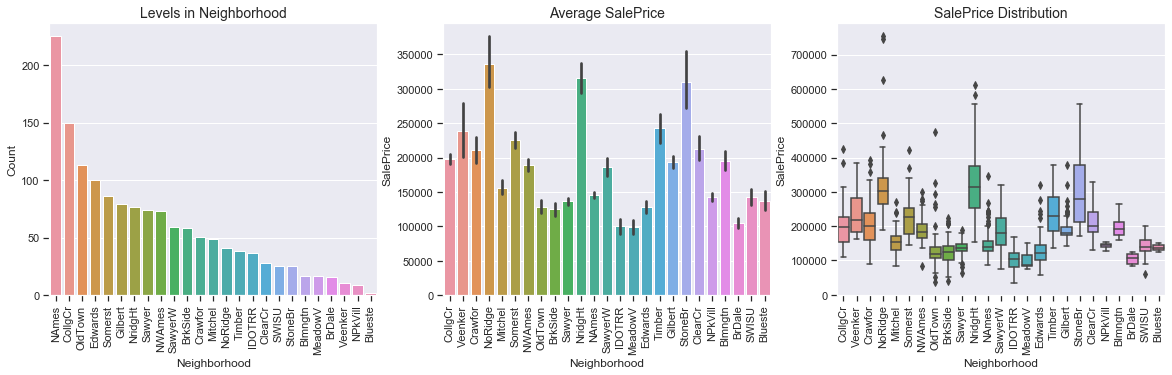

********************************************************************************


Variable       : Condition1
Levels         : 9

['Norm (1260)', 'Feedr (81)', 'Artery (48)', 'RRAn (26)', 'PosN (19)', 'RRAe (11)', 'PosA (8)', 'RRNn (5)', 'RRNe (2)']

********************************************************************************



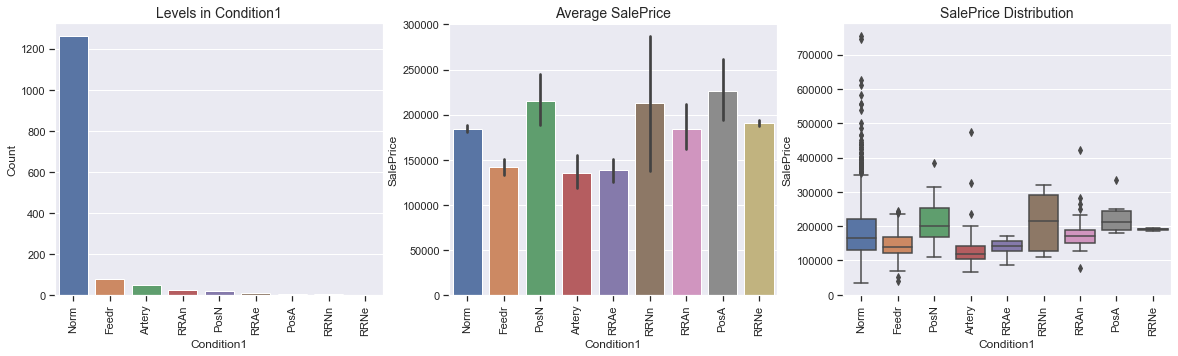

********************************************************************************


Variable       : BldgType
Levels         : 5

['1Fam (1220)', 'TwnhsE (114)', 'Duplex (52)', 'Twnhs (43)', '2fmCon (31)']

********************************************************************************



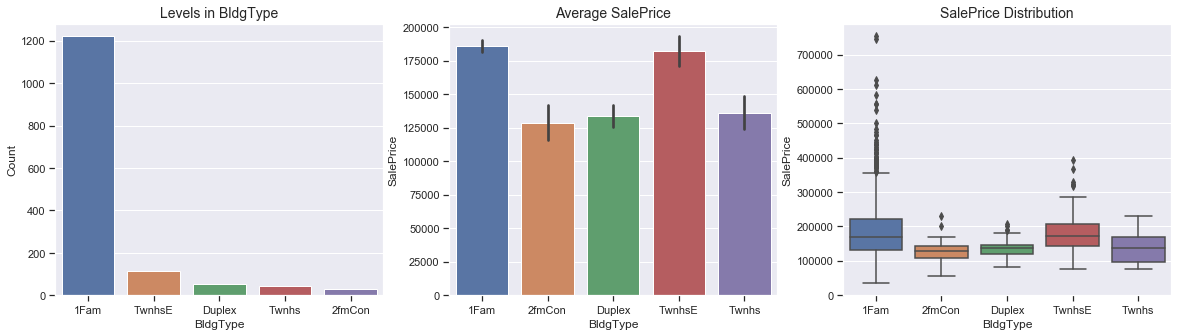

********************************************************************************


Variable       : HouseStyle
Levels         : 8

['1Story (726)', '2Story (445)', '1.5Fin (154)', 'SLvl (65)', 'SFoyer (37)', '1.5Unf (14)', '2.5Unf (11)', '2.5Fin (8)']

********************************************************************************



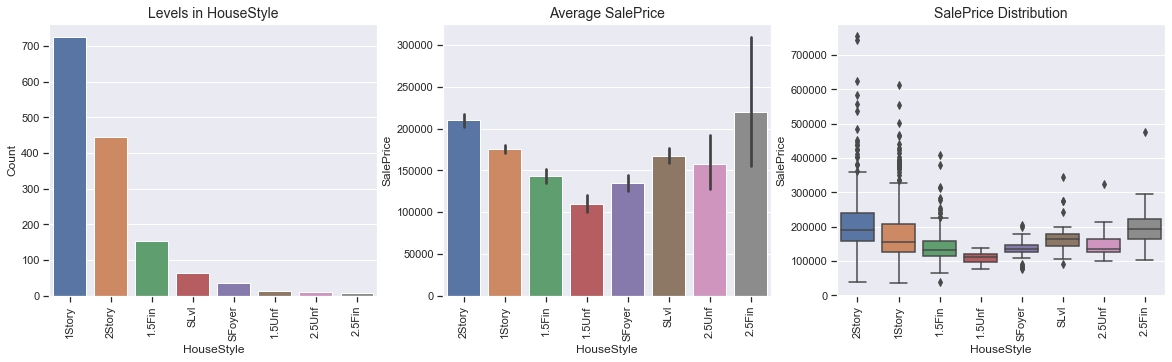

********************************************************************************


Variable       : RoofStyle
Levels         : 6

['Gable (1141)', 'Hip (286)', 'Flat (13)', 'Gambrel (11)', 'Mansard (7)', 'Shed (2)']

********************************************************************************



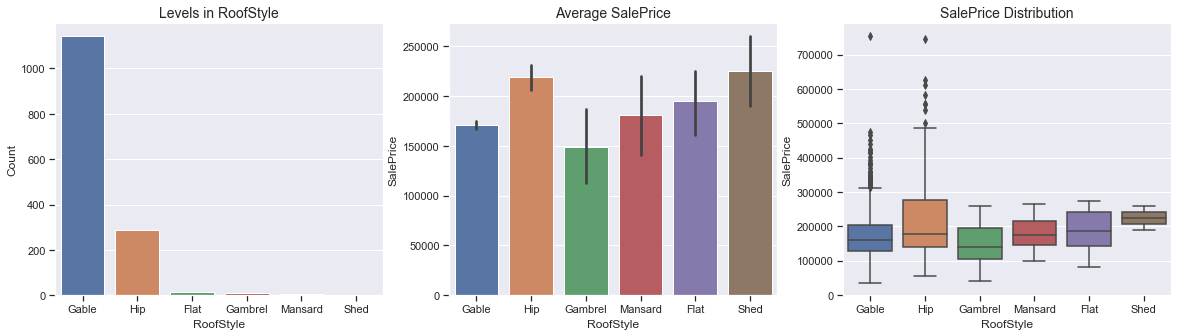

********************************************************************************


Variable       : Exterior1st
Levels         : 15

['VinylSd (515)', 'HdBoard (222)', 'MetalSd (220)', 'Wd Sdng (206)', 'Plywood (108)', 'CemntBd (61)', 'BrkFace (50)', 'WdShing (26)', 'Stucco (25)', 'AsbShng (20)', 'Stone (2)', 'BrkComm (2)', 'ImStucc (1)', 'AsphShn (1)', 'CBlock (1)']

********************************************************************************



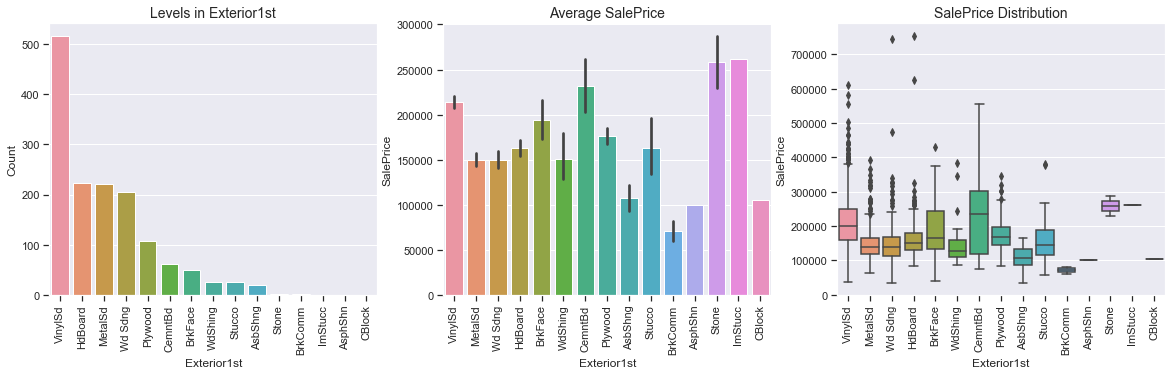

********************************************************************************


Variable       : Exterior2nd
Levels         : 16

['VinylSd (504)', 'MetalSd (214)', 'HdBoard (207)', 'Wd Sdng (197)', 'Plywood (142)', 'CmentBd (60)', 'Wd Shng (38)', 'Stucco (26)', 'BrkFace (25)', 'AsbShng (20)', 'ImStucc (10)', 'Brk Cmn (7)', 'Stone (5)', 'AsphShn (3)', 'Other (1)', 'CBlock (1)']

********************************************************************************



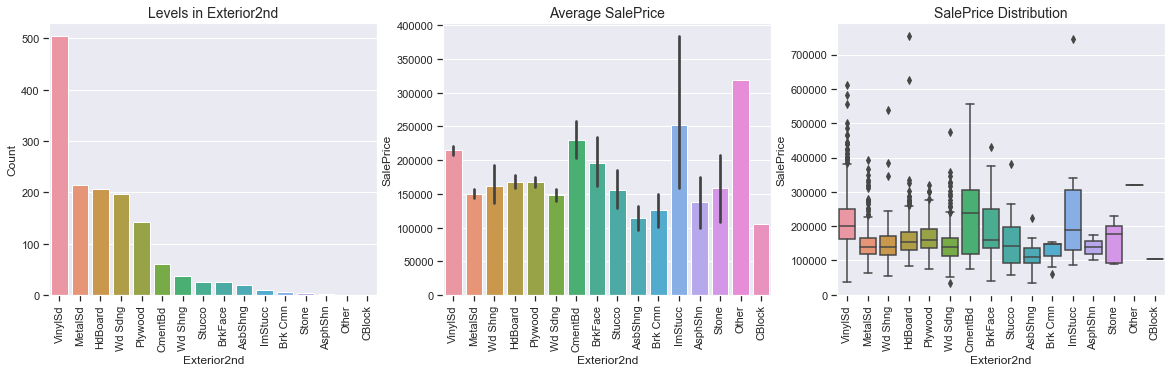

********************************************************************************


Variable       : MasVnrType
Levels         : 4

['None (872)', 'BrkFace (445)', 'Stone (128)', 'BrkCmn (15)']

********************************************************************************



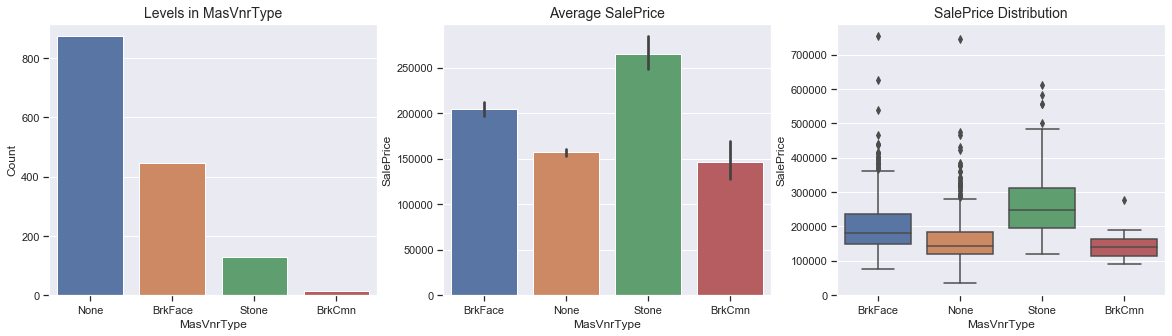

********************************************************************************


Variable       : Foundation
Levels         : 6

['PConc (647)', 'CBlock (634)', 'BrkTil (146)', 'Slab (24)', 'Stone (6)', 'Wood (3)']

********************************************************************************



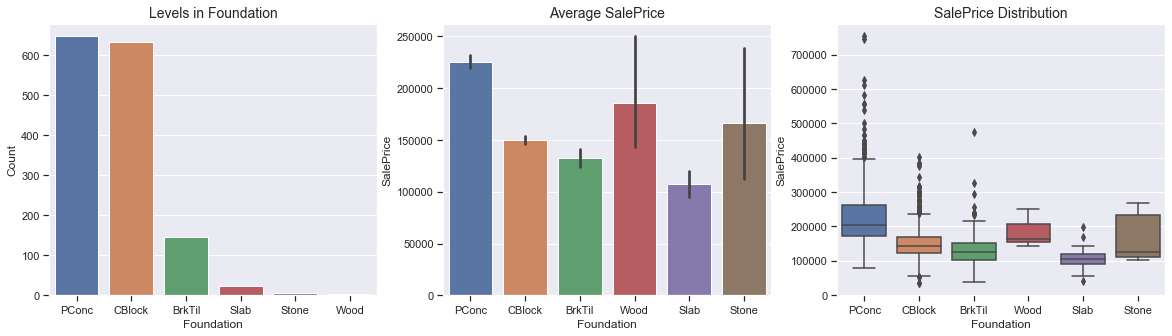

********************************************************************************


Variable       : BsmtExposure
Levels         : 5

['No (954)', 'Av (221)', 'Gd (134)', 'Mn (114)', 'NA (37)']

********************************************************************************



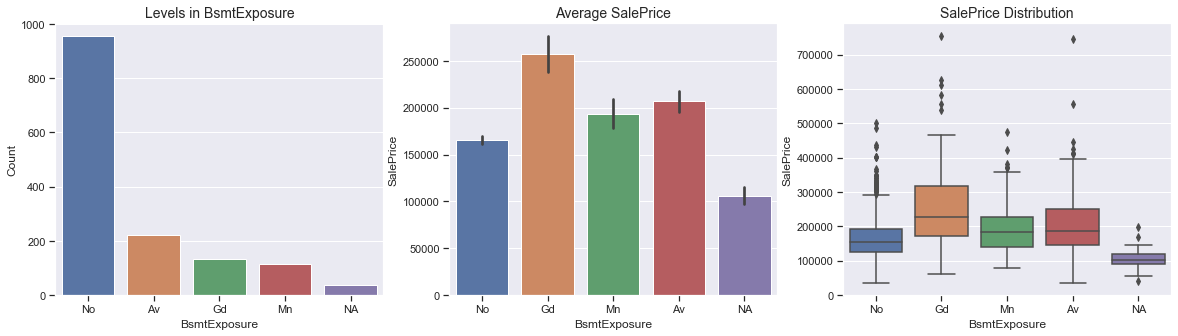

********************************************************************************


Variable       : BsmtFinType1
Levels         : 7

['Unf (430)', 'GLQ (418)', 'ALQ (220)', 'BLQ (148)', 'Rec (133)', 'LwQ (74)', 'NA (37)']

********************************************************************************



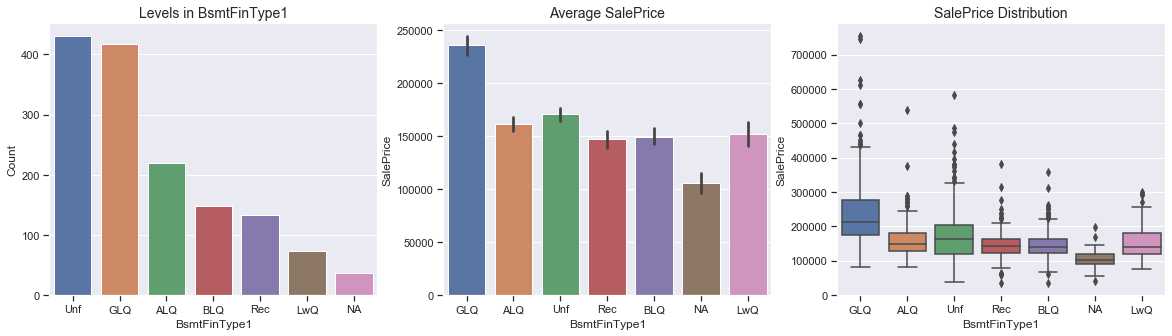

********************************************************************************


Variable       : BsmtFinType2
Levels         : 7

['Unf (1257)', 'Rec (54)', 'LwQ (46)', 'NA (37)', 'BLQ (33)', 'ALQ (19)', 'GLQ (14)']

********************************************************************************



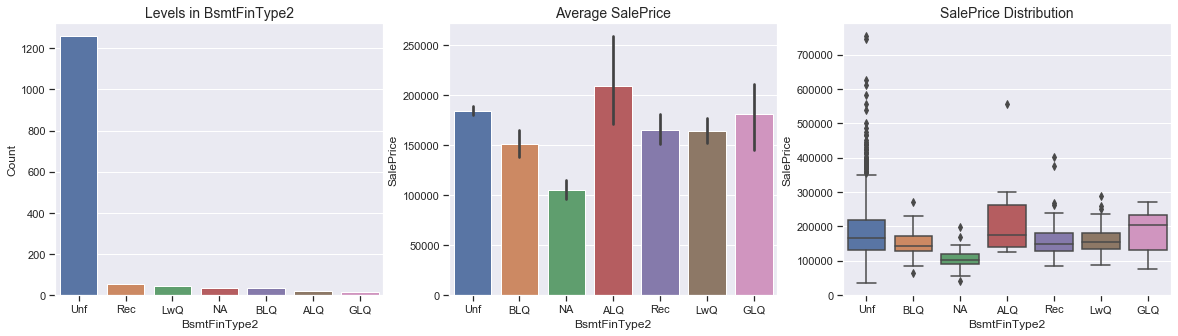

********************************************************************************


Variable       : CentralAir
Levels         : 2

['Y (1365)', 'N (95)']

********************************************************************************



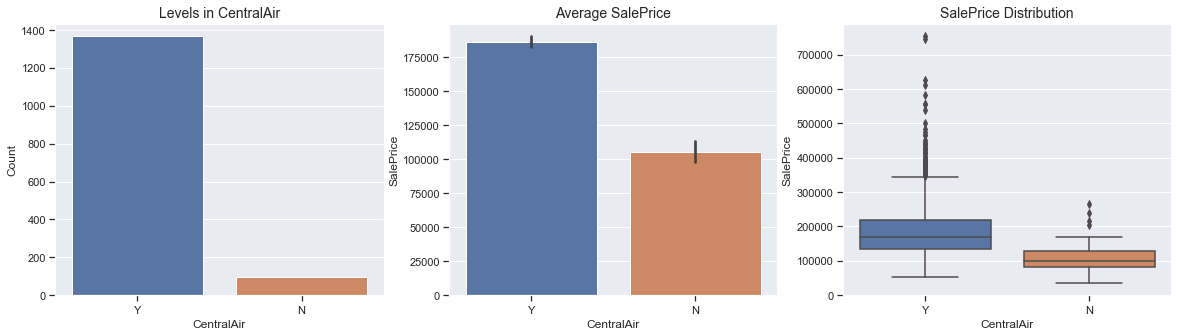

********************************************************************************


Variable       : Electrical
Levels         : 5

['SBrkr (1335)', 'FuseA (94)', 'FuseF (27)', 'FuseP (3)', 'Mix (1)']

********************************************************************************



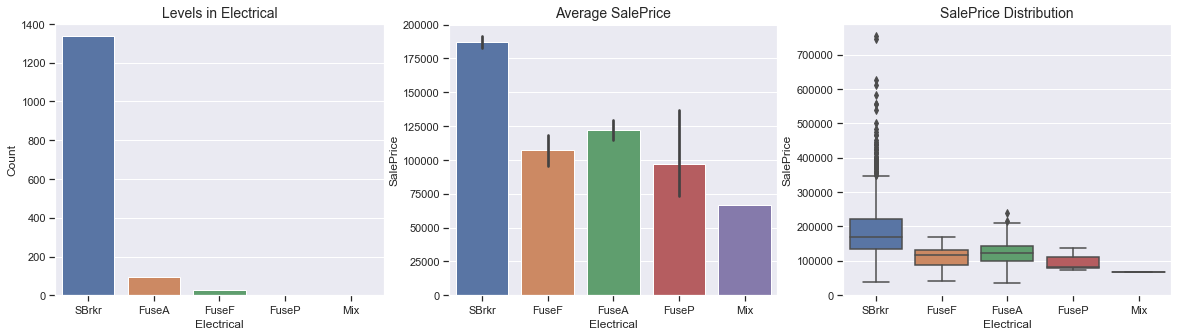

********************************************************************************


Variable       : Functional
Levels         : 7

['Typ (1360)', 'Min2 (34)', 'Min1 (31)', 'Mod (15)', 'Maj1 (14)', 'Maj2 (5)', 'Sev (1)']

********************************************************************************



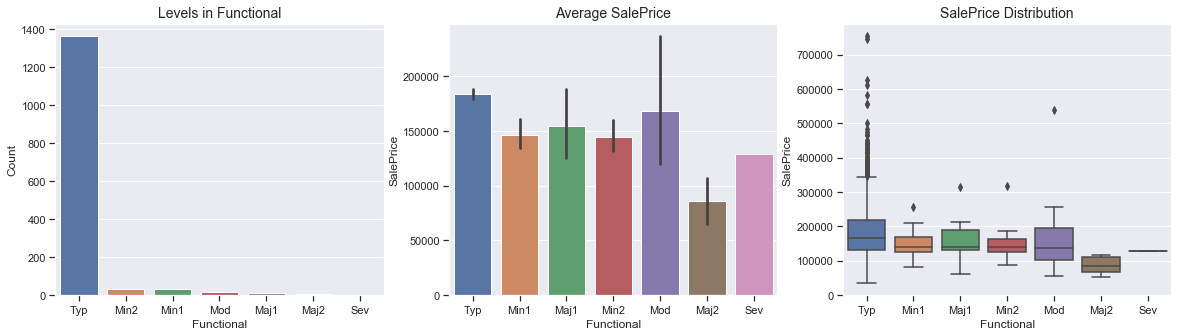

********************************************************************************


Variable       : GarageType
Levels         : 7

['Attchd (870)', 'Detchd (387)', 'BuiltIn (88)', 'NA (81)', 'Basment (19)', 'CarPort (9)', '2Types (6)']

********************************************************************************



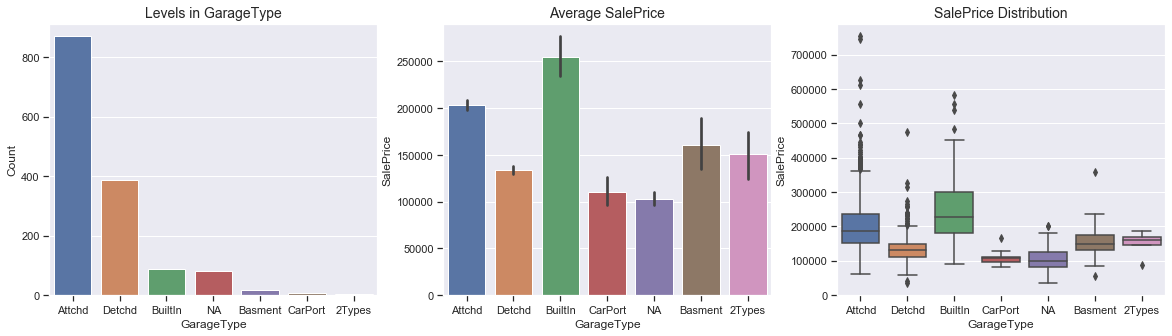

********************************************************************************


Variable       : GarageFinish
Levels         : 4

['Unf (605)', 'RFn (422)', 'Fin (352)', 'NA (81)']

********************************************************************************



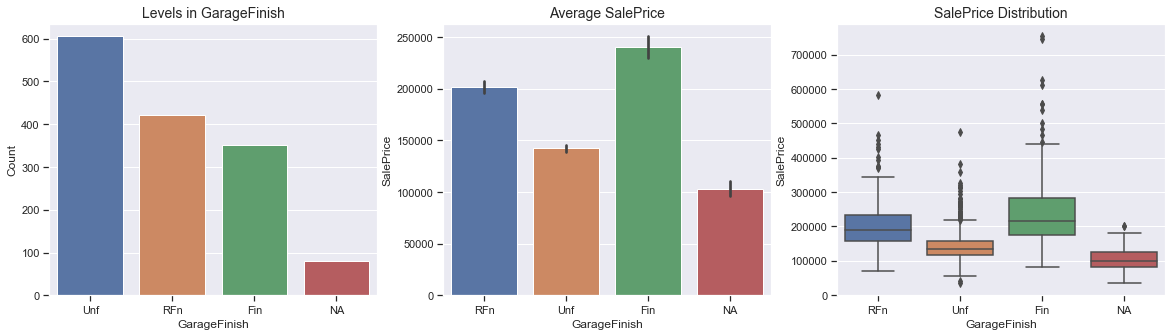

********************************************************************************


Variable       : PavedDrive
Levels         : 3

['Y (1340)', 'N (90)', 'P (30)']

********************************************************************************



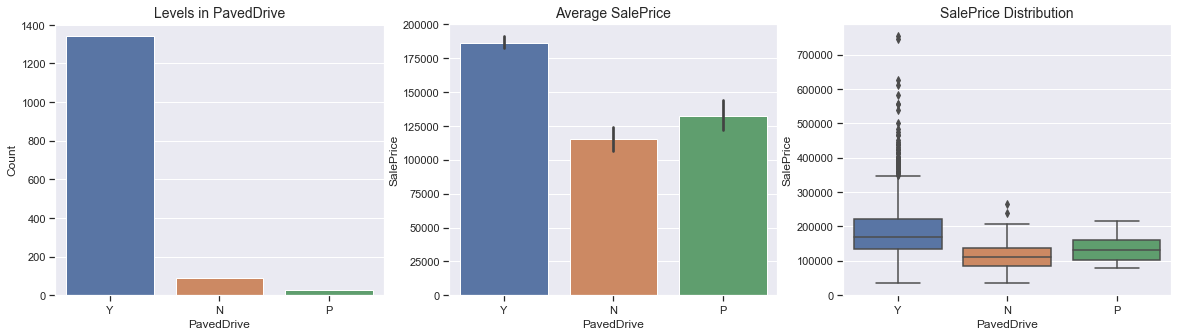

********************************************************************************



In [78]:
for column in others: visualize_categorical_variable(data = df, col = column, target = 'SalePrice')

__MSSubClass:__ Identifies the type of dwelling involved in the sale. These are represented numerically, but there is no ordinality and hence this has to be considered categorical. We have to create dummies rather than encoding this field.

In [79]:
df['MSSubClass'] = df['MSSubClass'].astype('str')

### 1.8.4. Converting to Binary Variables

__CentralAir__ has 2 levels - Yes or No. We will map them 1 and 0 respectively.

In [80]:
df['CentralAir'] = df['CentralAir'].map({'Y' : 1, 'N' : 0})

__LotShape__ has 4 levels. 

 - Reg - Regular - 925 records
 - IR1 - Slightly Irregular - 484 records
 - IR2 - Moderately Irregular - 41 records
 - IR3 - Irregular - 10 records
 
For IR1, IR2 and IR3, the mean price variability is not much and hence we will mark all these records as Ireg. Since this will have only 2 levels, we can encode regular as 1 and irregular as 0.

In [81]:
df['LotShape'] = df['LotShape'].map({'Reg' : 1, 'IR1' : 0, 'IR2' : 0, 'IR3' : 0})

__Functional__ has 7 levels. Home functionality (Assume typical unless deductions are warranted). 1360 records are marked as Typical (93%). We will map all other levels to Ded (indicating Deductions Warranted).

In [82]:
# There are very few records of category Housewife and Businessman. We will mark them as Others.

deductions = ['Min2', 'Min1', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal']

df.loc[df['Functional'].isin(deductions), 'Functional'] = 'Ded'

In [83]:
df['Functional'].value_counts()

Typ    1360
Ded     100
Name: Functional, dtype: int64

In [84]:
df['TypicalFunc'] = df['Functional']

In [85]:
df['TypicalFunc'] = df['TypicalFunc'].map({'Typ' : 1, 'Ded' : 0})

In [86]:
df.drop(columns = ['Functional'], inplace = True)

---

## 1.9. Creating Dummies

The categorical variables are not numeric and cannot be used directly in the model; hence need some treatment. We have to create dummy or indicator variables. If the variable has n distinct values we will create n-1 indicator variables.  

If there are only 2 levels then we can do a binary mapping (0 and 1). If there are more than 2 levels in the categorical variable, we have two options: 
 
 - __perform label encoding:__ convert the labels into machine readable numeric form.
 - __create dummies:__ for a categorical variable with n levels, we need to create n-1 dummy variables. The nth variable is redundant and may create multicollinearity issues. In Python, we can use the pd.get_dummies() function to create dummy variables from the data frame.
 
We have already handled the following categorical variables.

|Variable|Description|Data Type|Levels|Type of Variable|Action Taken|
|:---|:---|:---|---:|:---|:---|
|Id|Key Identifier|int64|1460|Key Value - Discrete|Converted into index of Datarame|
|PoolQC|Pool quality|object|3|Categorical - Ordinal|Dropped - Too many null values (99.52%).|
|MiscFeature|Miscellaneous feature|object|4|Categorical - Nominal|Dropped - Too many null values (96.30%).|
|Alley|Type of alley access to property|object|2|Categorical - Nominal|Dropped - Too many null values (93.77%).|
|Fence|Fence type|object|4|Categorical - Nominal|Dropped - Too many null values (80.75%).|
|Street|Type of road access to property|object|2|Categorical - Nominal|Dropped due to skewness and lack of variability.|
|Utilities|Type of utilities available|object|2|Categorical - Nominal|Dropped due to skewness and lack of variability.|
|LandSlope|Slope of property|object|3|Categorical - Nominal|Dropped due to skewness and lack of variability.|
|Condition2|Proximity to various conditions|object|8|Categorical - Nominal|Dropped due to skewness and lack of variability.|
|RoofMatl|Roof material|object|8|Categorical - Nominal|Dropped due to skewness and lack of variability.|
|Heating|Type of heating|object|6|Categorical - Nominal|Dropped due to skewness and lack of variability.|
|YearBuilt|Original construction date|int64|112|Categorical - Ordinal|Converted to Age at the time of selling|
|YearRemodAdd|Remodel date (same as YearBuilt if no remodeling)|int64|61|Categorical - Ordinal|Converted to Age at the time of selling|
|GarageYrBlt|Year garage was built|float64|97|Categorical - Ordinal|Converted to Age at the time of selling|
|ExterQual|Evaluates quality of the material on the exterior|object|4|Categorical - Ordinal|Mapped the quality condition to numeric values|
|ExterCond|Evaluates present condition of exterior material|object|5|Categorical - Ordinal|Mapped the quality condition to numeric values|
|BsmtQual|Evaluates the height of the basement|object|4|Categorical - Ordinal|Mapped the quality condition to numeric values|
|BsmtCond|Evaluates the general condition of the basement|object|4|Categorical - Ordinal|Mapped the quality condition to numeric values|
|HeatingQC|Heating quality and condition|object|5|Categorical - Ordinal|Mapped the quality condition to numeric values|
|KitchenQual|Kitchen quality|object|4|Categorical - Ordinal|Mapped the quality condition to numeric values|
|FireplaceQu|Fireplace quality|object|5|Categorical - Ordinal|Mapped the quality condition to numeric values|
|GarageQual|Garage quality|object|5|Categorical - Ordinal|Mapped the quality condition to numeric values|
|GarageCond|Garage condition|object|5|Categorical - Ordinal|Mapped the quality condition to numeric values|
|LotShape|General shape of property|object|4|Categorical - Nominal|Reduced to 2 levels and mapped to 1 (Reg) and 0 (IRs)|
|Functional|Home functionality|object|7|Categorical - Nominal|Reduced to 2 levels and mapped to 1 (Typ) and 0 (Others)|
|CentralAir|Central air conditioning|object|2|Categorical - Nominal|Mapped Y and N values to 1 and 0 respectively.|

For the following categorical variables we need to create dummies.

|Variable|Description|Data Type|Levels|Type of Variable|
|:---|:---|:---|---:|:---|
|MSSubClass|Identifies the type of dwelling involved in the sale.|int64|15|Categorical - Nominal|
|MSZoning|Identifies the general zoning classification of the sale.|object|5|Categorical - Nominal|
|LandContour|Flatness of the property|object|4|Categorical - Nominal|
|LotConfig|Lot configuration|object|5|Categorical - Nominal|
|Neighborhood|Physical locations within Ames city limits|object|25|Categorical - Nominal|
|Condition1|Proximity to various conditions|object|9|Categorical - Nominal|
|BldgType|Type of dwelling|object|5|Categorical - Nominal|
|HouseStyle|Style of dwelling|object|8|Categorical - Nominal|
|RoofStyle|Type of roof|object|6|Categorical - Nominal|
|Exterior1st|Exterior covering on house|object|15|Categorical - Nominal|
|Exterior2nd|Exterior covering on house (if more than one material)|object|16|Categorical - Nominal|
|MasVnrType|Masonry veneer type|object|4|Categorical - Nominal|
|Foundation|Type of foundation|object|6|Categorical - Nominal|
|Electrical|Electrical system|object|5|Categorical - Nominal|
|PavedDrive|Paved driveway|object|3|Categorical - Nominal|
|SaleType|Type of sale|object|9|Categorical - Nominal|
|SaleCondition|Condition of sale|object|6|Categorical - Nominal|
|GarageType|Garage location|object|6|Categorical - Nominal|
|GarageFinish|Interior finish of the garage|object|3|Categorical - Nominal|
|BsmtExposure|Refers to walkout or garden level walls|object|4|Categorical - Nominal|
|BsmtFinType1|Rating of basement finished area|object|6|Categorical - Nominal|
|BsmtFinType2|Rating of basement finished area (if multiple types)|object|6|Categorical - Nominal|

In [87]:
dfcopy = df.copy() # Keep a copy of the data set with transformations made for later reference

In [88]:
# We will create dummies with drop_first = True

dummy_set1 = ['MSSubClass', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType',
              'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation']

# We will create dummies with drop_first = False and then manually remove certain columns

dummy_set2 = ['MSZoning', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'MasVnrType',
              'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType', 'SaleCondition']

In [89]:
df = pd.get_dummies(df, columns = dummy_set1, drop_first = True)

In [90]:
df = pd.get_dummies(df, columns = dummy_set2, drop_first = False)

In [91]:
cols_to_drop = ['MSZoning_C (all)', 'BsmtExposure_NA', 'BsmtFinType2_NA', 'BsmtFinType1_NA',
                'Electrical_Mix', 'MasVnrType_None', 'GarageType_NA','GarageFinish_NA',
                'PavedDrive_P', 'SaleType_Oth', 'SaleCondition_AdjLand']
                
df.drop(columns = cols_to_drop, inplace = True)

In [92]:
df.shape

(1460, 203)

---

## 1.10 Check for Multicollinearity

In [93]:
%matplotlib inline

In [94]:
corr = df.corr()

(202.0, 0.0)

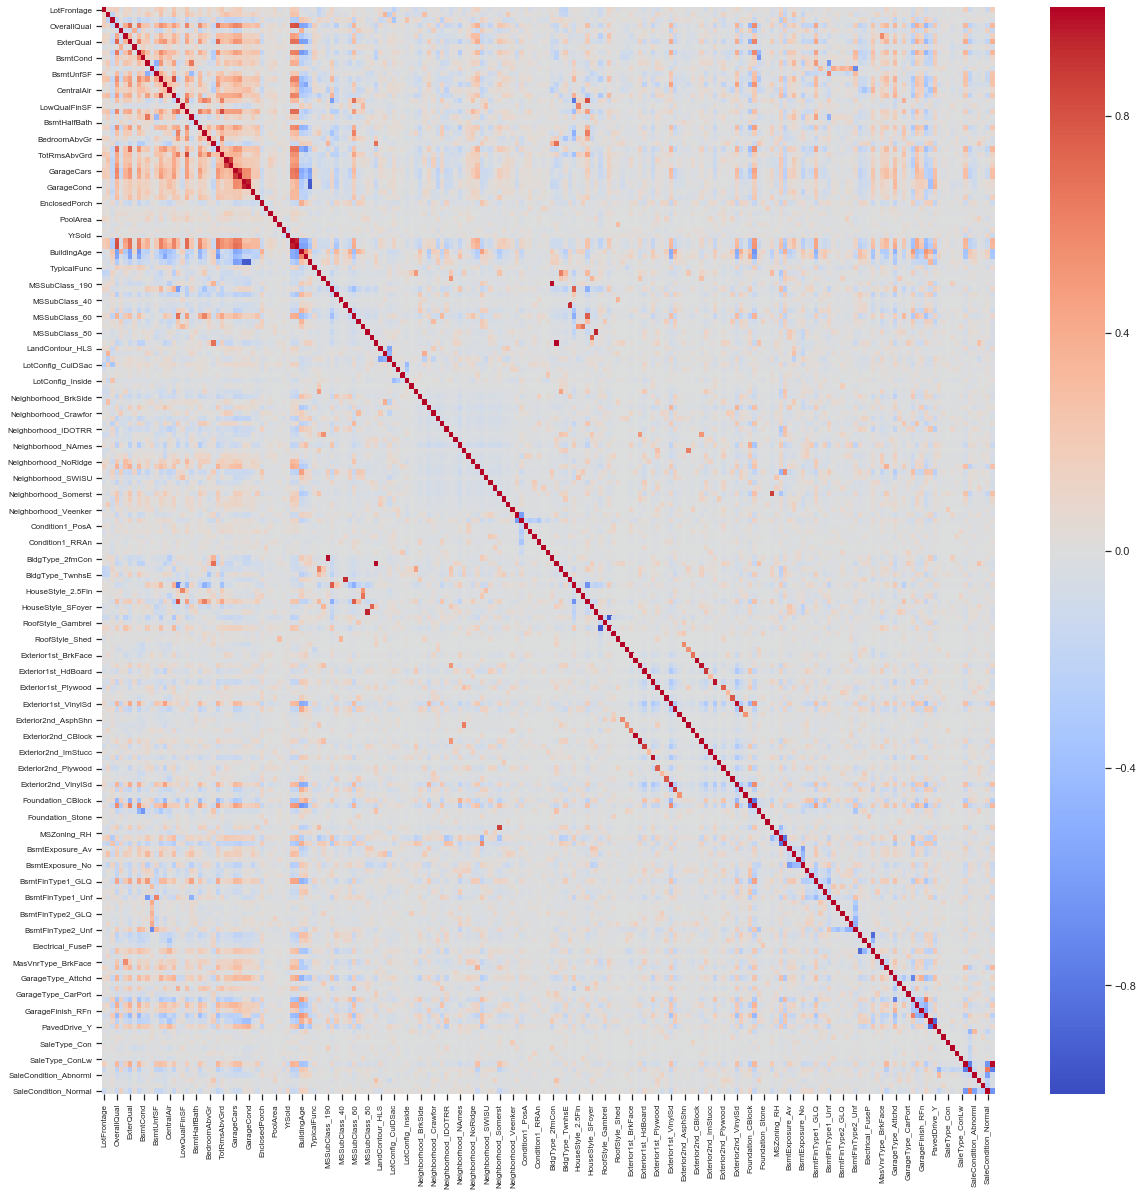

In [95]:
# plot correlation heat map for numeric variables

f, ax = plt.subplots(figsize=(20, 20))

heatmap = sns.heatmap(corr, vmin = -1, vmax = 1, cmap = "coolwarm", annot = False)

heatmap.set_yticklabels(heatmap.get_yticklabels(), size = 8)
heatmap.set_xticklabels(heatmap.get_xticklabels(), size = 8)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

# due to a bug in seaborn the first and last row square are getting cut in half - the following code fixes it
bottom, top = ax.get_ylim(); ax.set_ylim(bottom + 0.5, top - 0.5)

---

# Section 2: Model Building

## 2.1 Splitting the Dataset (Train-Test)

Now that we have understood the data, addressed the data quality issues and had sufficiently dealt with the categorical variables, we are ready to build the model. Before that we have to split the data set into train data and test data. The algorithm learns from the train data to get deeper understanding on the target variable (price) and uncovers patterns and relationships with other features in the dataset.

In [96]:
import sklearn as skl
from sklearn.model_selection import train_test_split

In [97]:
np.random.seed(0)

In [98]:
train, test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [99]:
train.shape

(1021, 203)

In [100]:
test.shape

(438, 203)

---

## 2.2 Rescaling the Features 

Scaling doesn't impact our model. So we need to rescale the variables so that they have a comparable scale. Otherwise, the coefficients obtained while fitting the regression model might be very large or very small as compared to the other coefficients. There are two methods of scaling that we can go for:

 - __Standardization__ - (x - mu) / sigma - mu = 0 and sigma = 1
 - __Normalization__ - (x - xmin) / (xmax - xmin) - between -1 and 1
 
Here we apply normalization (Max Min Scaling). The max min scaling can be applied on the numeric variables so that we get a normalized value between 0 and 1 for these variables. 

Note: Scaling should be performed after removing the test set from the entire dataset. We will fit the scaler to the train data and use the same to transform the test data.

In [101]:
from sklearn.preprocessing import StandardScaler

In [102]:
train.head()

LotFrontage  LotArea  LotShape  OverallQual  OverallCond  MasVnrArea  ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  HeatingQC  CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Fireplaces  FireplaceQu  GarageCars  GarageArea  GarageQual  GarageCond  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  SalePrice  SalePriceLog  BuildingAge  RemodeledAge  GarageAge  TypicalFunc  MSSubClass_160  MSSubClass_180  MSSubClass_190  MSSubClass_20  MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  LandContour_HLS  LandContour_Low  LandContour_Lvl  LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  Neighborhood_Blueste  Neighborhood_BrDale  Neighborhood_BrkSide  \
Id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
211          67.0     5604         1            5            6         0.0          5          5         5         5         468           0        396          864          5           0       864         0             0        864             1             0         1         0             2             1            5             5           0            0           0           0           0           0           0            0             96          0            0         0        0       4       8      98000     11.492723           83            58     2008.0            1               0               0               0              0              1              0              0              0              0              0              0              0              0              0                0                0                1                  0              0              0                 1                     0                    0                     0   
319          90.0     9900         1            7            5       256.0          7          5         7         5         987           0        360         1347          9           1      1372      1274             0       2646             1             0         2         1             4             1            7             9           1            5           3         656           5           5         340           60            144          0            0         0        0       4       9     260000     12.468437           16            16       16.0            1               0               0               0              0              0              0              0              0              1              0              0              0              0              0                0                1                0                  0              0              0                 1                     0                    0                     0   
240          52.0     8741         1            6            4         0.0

In [103]:
features = ['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'WoodDeckSF', 'GarageArea', 'BsmtUnfSF', 
            'TotalBsmtSF', 'BsmtFinSF1', 'LotFrontage', 'LotArea', 'MasVnrArea', 'LowQualFinSF', 
            'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'BsmtFinSF2', 
            'MiscVal', 'SalePrice', 'SalePriceLog', 'BuildingAge', 'RemodeledAge', 'GarageAge']

In [104]:
scaler = StandardScaler()

train[features] = scaler.fit_transform(train[features])

In [105]:
train.head()

LotFrontage   LotArea  LotShape  OverallQual  OverallCond  MasVnrArea  ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  HeatingQC  CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Fireplaces  FireplaceQu  GarageCars  GarageArea  GarageQual  GarageCond  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea   MiscVal  MoSold  YrSold  SalePrice  SalePriceLog  BuildingAge  RemodeledAge  GarageAge  TypicalFunc  MSSubClass_160  MSSubClass_180  MSSubClass_190  MSSubClass_20  MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  LandContour_HLS  LandContour_Low  LandContour_Lvl  LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  Neighborhood_Blueste  Neighborhood_BrDale  Neighborhood_BrkSide  \
Id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
211      0.273876 -0.473765         1            5            6   -0.558025          5          5         5         5    0.043512   -0.293313  -0.374367    -0.430911          5           0 -0.765065 -0.787597     -0.124502  -1.228053             1             0         1         0             2             1            5             5           0            0           0   -2.217786           0           0   -0.743160    -0.709347       1.150231  -0.121922    -0.275126 -0.062302 -0.084263       4       8  -1.042855     -1.335437     1.529604      1.704092   4.069433            1               0               0               0              0              1              0              0              0              0              0              0              0              0              0                0                0                1                  0              0              0                 1                     0                    0                     0   
319      0.942770 -0.056845         1            7            5    0.809137          7          5         7         5    1.160345   -0.293313  -0.454644     0.621579          9           1  0.511914  2.140556     -0.124502   2.123103             1             0         2         1             4             1            7             9           1            5           3    0.867506           5           5    1.989482     0.197980       1.910043  -0.121922    -0.275126 -0.062302 -0.084263       4       9   1.006390      1.125545    -0.677573     -0.333918  -0.273527            1               0               0               0              0              0              0              0              0              1              0              0              0              0              0                0                1                0                  0              0              0                 1                     0                    0                     0   
240     -0.162360 -0.169324         1            6            4   

In [106]:
test[features] = scaler.transform(test[features])

In [107]:
test.head()

LotFrontage   LotArea  LotShape  OverallQual  OverallCond  MasVnrArea  ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  HeatingQC  CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Fireplaces  FireplaceQu  GarageCars  GarageArea  GarageQual  GarageCond  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch   PoolArea   MiscVal  MoSold  YrSold  SalePrice  SalePriceLog  BuildingAge  RemodeledAge  GarageAge  TypicalFunc  MSSubClass_160  MSSubClass_180  MSSubClass_190  MSSubClass_20  MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  LandContour_HLS  LandContour_Low  LandContour_Lvl  LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  Neighborhood_Blueste  Neighborhood_BrDale  Neighborhood_BrkSide  \
Id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
1437     0.070299 -0.144189         1            4            6   -0.558025          5          5         5         5    0.361992   -0.293313  -0.704396    -0.430911          5           1 -0.765065 -0.787597     -0.124502  -1.228053             0             0         1         0             3             1            5             5           0            0           2    0.265498           5           5   -0.743160    -0.709347      -0.369395  -0.121922    -0.275126  -0.062302 -0.084263       5       7  -0.758237     -0.814135    -0.018714      0.636563  -0.236463            1               0               0               0              1              0              0              0              0              0              0              0              0              0              0                0                0                1                  0              1              0                 0                     0                    0                     0   
58       0.913688  0.112505         0            7            5   -0.558025          7          5         7         5   -0.963574   -0.293313   0.660317    -0.439628          9           1 -0.775120  1.189021     -0.124502   0.381706             0             0         2         1             3             1            7             7           0            0           2    0.439515           5           5   -0.743160     0.349201      -0.369395  -0.121922    -0.275126  -0.062302 -0.084263       8       6   0.203137      0.419270    -1.138774     -1.013254  -0.304049            1               0               0               0              0              0              0              0              0              1              0              0              0              0              0                0                0                1                  0              0              0                 0                     0                    0                     0   
781      0.157546 -0.253368         1            7            

In [108]:
y_train = train.pop('SalePriceLog')
X_train = train.drop('SalePrice', axis = 1)

In [109]:
y_test = test.pop('SalePriceLog')
X_test = test.drop('SalePrice', axis = 1)

In [110]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1021, 201)
(1021,)
(438, 201)
(438,)


---

## 2.3. Linear Regression with RFE

Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. Since in our dataset we have 33 features, selecting them manually, one by one, or taking all the features and eliminating them one by one is not feasible. So we will use RFE to choose 10 features that are significant.

In [111]:
import statsmodels.api as sm

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

In [112]:
%matplotlib inline

### 2.3.1. Running RFE with different values for number of features

In [113]:
# Running RFE and building model with number of the input variable equal to 5, 15, 25, ... 215

metric = pd.DataFrame(columns = ['Features', 'trainR2', 'trainadjR2', 'testR2', 'testadjR2'])

n1 = X_train.shape[0] # number of observations in train data
n2 = X_test.shape[0]  # number of observations in test data

for p in range(15, 220, 10):

    lm = LinearRegression()
    lm.fit(X_train, y_train)

    # we select p features using RFE
    
    rfe = RFE(lm, p)
    rfe = rfe.fit(X_train, y_train)   
    
    col = X_train.columns[rfe.support_]

    # We select only the columns given by RFE for building the model
    
    X_train_rfe = X_train[col]
    
    # Adding a constant variable 
    
    X_train_lm = sm.add_constant(X_train_rfe) 
    
    # Fitting the model with train data

    lm = sm.OLS(y_train, X_train_lm).fit() 
    
    # Predicting the target variable with the model

    y_train_pred = lm.predict(X_train_lm)
    
    # Computing the r2 score and adjusted r2 score for train data
    
    train_r2score = r2_score(y_true = y_train, y_pred = y_train_pred)
    train_adj_r2 = 1 - ((1 - train_r2score) * (n1 - 1) / (n1 - p - 1))
    
    # We select only the columns given by RFE from test data
    
    X_test_rfe = X_test[col]
    
    # Adding a constant variable 
    
    X_test_lm = sm.add_constant(X_test_rfe)
    
    # Predicting the target variable for test data using the model built with train data
    
    y_test_pred = lm.predict(X_test_lm)
    
    # Computing the r2 score and adjusted r2 score for test data
        
    test_r2score = r2_score(y_true = y_test, y_pred = y_test_pred)
    test_adj_r2 = 1 - ((1 - test_r2score) * (n2 - 1) / (n2 - p - 1))
    
    # Adding the metrics to a data frame

    metric = metric.append({'Features'   : p,
                            'trainR2'    : train_r2score,
                            'testR2'     : test_r2score,
                            'trainadjR2' : train_adj_r2,
                            'testadjR2'  : test_adj_r2} , ignore_index = True)


In [114]:
metric

Features   trainR2  trainadjR2    testR2  testadjR2
0       15.0  0.618183    0.612484  0.574388   0.559259
1       25.0  0.809790    0.805011  0.783585   0.770453
2       35.0  0.837887    0.832127  0.811910   0.795534
3       45.0  0.840098    0.832718  0.813824   0.792451
4       55.0  0.841017    0.831956  0.809830   0.782449
5       65.0  0.857448    0.847746  0.809489   0.776200
6       75.0  0.876977    0.867213  0.820571   0.783397
7       85.0  0.878713    0.867687  0.816613   0.772329
8       95.0  0.902804    0.892822  0.854426   0.813989
9      105.0  0.913165    0.903201  0.876013   0.836801
10     115.0  0.915220    0.904446  0.874252   0.829342
11     125.0  0.918464    0.907076  0.879128   0.830701
12     135.0  0.921067    0.909026  0.878123   0.823641
13     145.0  0.921562    0.908563  0.878958   0.818852
14     155.0  0.923677    0.910000  0.882530   0.817962
15     165.0  0.925045    0.910580  0.881786   0.810075
16     175.0  0.926682    0.911498  0.881033   0.801570
17     185.0  0.927559    0.911509  0.879239   0.790586
18     195.0  0.927995    0.910976  0.879321   0.782080
19     205.0  0.928078    0.909987  0.878937   0.771963
20     215.0  0.928078    0.908869  0.878937   0.761691

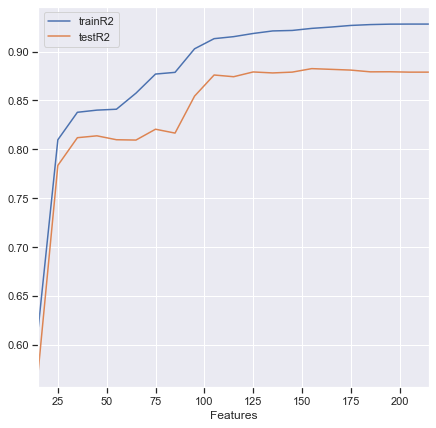

In [115]:
metric.plot.line(x='Features', y=['trainR2', 'testR2'], figsize=(7, 7))

We can see that a model built with 105 features is giving the optimal R2 Score for both train and test. We see that with less parameters the r2 score is low. But if we increase the number of features, the model starts to better predictability in train data, but with test data the same level of predictability is not achieved. Let us use advanced regression models.

### 2.3.2. Applying Cross Validation with RFE

In [116]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [117]:
%matplotlib inline

In [118]:
# creating a cross-validation scheme

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters to tune

params = [{'n_features_to_select': list(range(10, 40, 5))}]

# perform grid search

lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# call GridSearchCV()

model = GridSearchCV(estimator = rfe, 
                     param_grid = params, 
                     scoring= 'r2', 
                     cv = folds, 
                     verbose = 1,
                     return_train_score=True)      

# fit the model

model.fit(X_train, y_train)  

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   27.0s finished
C:\Users\jnvd\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             error_score='raise-deprecating',
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=None, step=1, verbose=0),
             iid='warn', n_jobs=None,
             param_grid=[{'n_features_to_select': [10, 15, 20, 25, 30, 35]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [119]:
cv_results = pd.DataFrame(model.cv_results_)

In [120]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_features_to_select', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'], dtype='object')

In [121]:
cv_results[['param_n_features_to_select', 'mean_test_score', 'mean_train_score']]

param_n_features_to_select  mean_test_score  mean_train_score
0                         10         0.354128          0.407260
1                         15         0.410462          0.476386
2                         20         0.624999          0.701916
3                         25         0.736392          0.809124
4                         30         0.758921          0.822698
5                         35         0.767936          0.830898

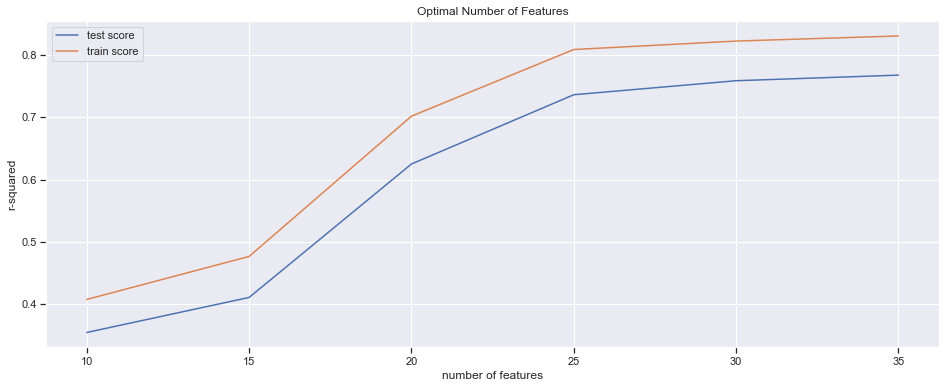

In [122]:
# plotting cv results

plt.figure(figsize=(16,6))
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

### 2.3.3. Feature Elimination with RFE

Now that we know the optimal number of features to get a good R2 score, let us reduce the number of features with RFE before applying Ridget and Lasso Regression. We will go with 120 features based on the calculation done in section 2.3.1.

In [123]:
lm = LinearRegression()
lm.fit(X_train, y_train)
   
rfe = RFE(lm, 120)
rfe = rfe.fit(X_train, y_train)   
    
col = X_train.columns[rfe.support_]

In [124]:
X_train = X_train[col]

In [125]:
X_train.head()

OverallQual  OverallCond  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  KitchenAbvGr  KitchenQual  GarageCars  BuildingAge  GarageAge  TypicalFunc  MSSubClass_160  MSSubClass_190  MSSubClass_20  MSSubClass_45  MSSubClass_50  MSSubClass_70  MSSubClass_80  MSSubClass_85  MSSubClass_90  LandContour_HLS  LandContour_Low  LandContour_Lvl  LotConfig_CulDSac  LotConfig_FR3  Neighborhood_Blueste  Neighborhood_BrkSide  Neighborhood_ClearCr  Neighborhood_CollgCr  Neighborhood_Crawfor  Neighborhood_Gilbert  Neighborhood_MeadowV  Neighborhood_NWAmes  Neighborhood_NoRidge  Neighborhood_NridgHt  Neighborhood_SWISU  Neighborhood_SawyerW  Neighborhood_Somerst  Neighborhood_StoneBr  Neighborhood_Timber  Neighborhood_Veenker  Condition1_Norm  Condition1_PosA  Condition1_RRAn  Condition1_RRNe  Condition1_RRNn  BldgType_2fmCon  BldgType_Duplex  BldgType_TwnhsE  HouseStyle_1.5Unf  \
Id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
211             5            6    0.043512   -0.293313  -0.374367    -0.430911           0 -0.765065 -0.787597     -0.124502  -1.228053             1             0         1         0             1            5           0     1.529604   4.069433            1               0               0              0              0              0              0              0              0              0                0                0                1                  0              0                     0                     0                     0                     0                     0                     0                     0                    0                     0                     0                   0                     0                     0                     0                    0                     0                1                0                0                0                0                0                0                0                  0   
319             7            5    1.160345   -0.293313  -0.454644     0.621579           1  0.511914  2.140556     -0.124502   2.123103             1             0         2         1             1            7           3    -0.677573  -0.273527            1               0               0              0              0              0              0              0              0              0                0                1                0                  0              0                     0                     0                     0                     0                     0                     0                     0                    0                     1                     0                   0                     0                     0                     0                    0                     0                1                0                0                0                0                0                0                0                  0   
240             6            4   -0.761296   -0.293313

In [126]:
X_test = X_test[col]

In [127]:
X_test.head()

OverallQual  OverallCond  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  KitchenAbvGr  KitchenQual  GarageCars  BuildingAge  GarageAge  TypicalFunc  MSSubClass_160  MSSubClass_190  MSSubClass_20  MSSubClass_45  MSSubClass_50  MSSubClass_70  MSSubClass_80  MSSubClass_85  MSSubClass_90  LandContour_HLS  LandContour_Low  LandContour_Lvl  LotConfig_CulDSac  LotConfig_FR3  Neighborhood_Blueste  Neighborhood_BrkSide  Neighborhood_ClearCr  Neighborhood_CollgCr  Neighborhood_Crawfor  Neighborhood_Gilbert  Neighborhood_MeadowV  Neighborhood_NWAmes  Neighborhood_NoRidge  Neighborhood_NridgHt  Neighborhood_SWISU  Neighborhood_SawyerW  Neighborhood_Somerst  Neighborhood_StoneBr  Neighborhood_Timber  Neighborhood_Veenker  Condition1_Norm  Condition1_PosA  Condition1_RRAn  Condition1_RRNe  Condition1_RRNn  BldgType_2fmCon  BldgType_Duplex  BldgType_TwnhsE  HouseStyle_1.5Unf  \
Id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
1437            4            6    0.361992   -0.293313  -0.704396    -0.430911           1 -0.765065 -0.787597     -0.124502  -1.228053             0             0         1         0             1            5           2    -0.018714  -0.236463            1               0               0              1              0              0              0              0              0              0                0                0                1                  0              0                     0                     0                     0                     0                     0                     0                     0                    0                     0                     0                   0                     0                     0                     0                    0                     0                1                0                0                0                0                0                0                0                  0   
58              7            5   -0.963574   -0.293313   0.660317    -0.439628           1 -0.775120  1.189021     -0.124502   0.381706             0             0         2         1             1            7           2    -1.138774  -0.304049            1               0               0              0              0              0              0              0              0              0                0                0                1                  0              0                     0                     0                     0                     1                     0                     0                     0                    0                     0                     0                   0                     0                     0                     0                    0                     0                1                0                0                0                0                0                0                0                  0   
781             7            5   -0.963574   -0.293313

---

## 2.4. Ridge Regression

### 2.4.1. Grid Search to find Optimal Alpha

In [128]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [129]:
%matplotlib inline

In [130]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation

folds = 5

model = GridSearchCV(estimator = ridge, 
                     param_grid = params, 
                     scoring= 'neg_mean_absolute_error', 
                     cv = folds, 
                     return_train_score=True,
                     verbose = 1)            

model.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [131]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha             params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score  split0_train_score  split1_train_score  split2_train_score  split3_train_score  split4_train_score  mean_train_score  std_train_score
0       0.003990      0.001092         0.001396    4.887141e-04      0.0001  {'alpha': 0.0001}          -0.236178          -0.220361          -0.260271          -0.221000          -0.225812        -0.232728        0.014885               25           -0.204308           -0.182596           -0.192439           -0.210398           -0.208112         -0.199570         0.010503
1       0.004389      0.000489         0.001595    4.886752e-04       0.001   {'alpha': 0.001}          -0.236140          -0.220280          -0.260273          -0.220934          -0.225814        -0.232691        0.014907               24           -0.204313           -0.182576           -0.192442           -0.210391           -0.208108         -0.199566         0.010508
2       0.005385      0.000489         0.001396    4.885584e-04        0.01    {'alpha': 0.01}          -0.235902          -0.219826          -0.260257          -0.220386          -0.225775        -0.232432        0.015057               23           -0.204330           -0.182542           -0.192456           -0.210335           -0.208094         -0.199551         0.010505
3       0.003790      0.000399         0.000997    3.989506e-07        0.05    {'alpha': 0.05}          -0.235102          -0.219318          -0.260009          -0.218563          -0.225391        -0.231680        0.015346               22           -0.204231           -0.182595           -0.192459           -0.210143           -0.207986         -0.199483         0.010421
4       0.004389      0.001017         0.002194    3.988029e-04         0.1     {'alpha': 0.1}          -0.234249          -0.219079          -0.259657          -0.216630          -0.224878        -0.230902        0.015599               20           -0.204081           -0.182600           -0.192440           -0.209953           -0.207842         -0.199383         0.010346

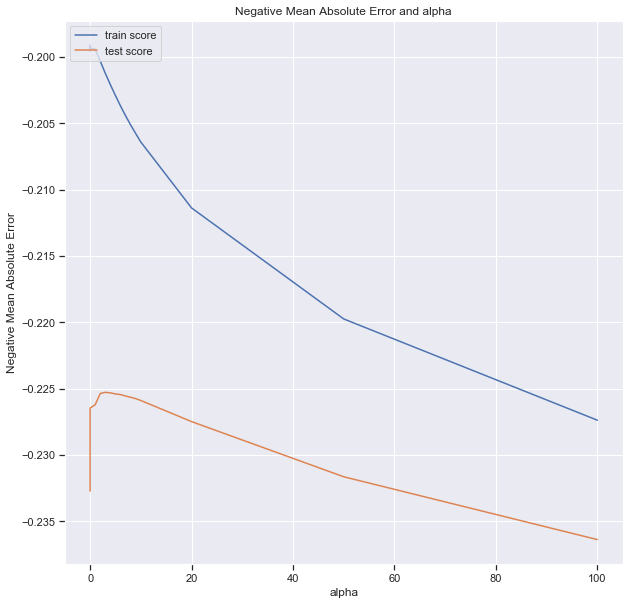

In [132]:
# plotting mean test and train scoes with alpha
plt.figure(figsize=(10,10)) 

cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [133]:
model.best_params_

{'alpha': 3.0}

### 2.4.2. Building the Model with Optimal Alpha

In [134]:
ridge = Ridge(alpha = 3)
ridge.fit(X_train, y_train)

Ridge(alpha=3, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [135]:
ridge.intercept_

-3.60721004548634

In [136]:
ridge.coef_

array([ 0.1538266 ,  0.09329233, -0.03127109,  0.01782816,  0.01006139,
       -0.0152001 ,  0.20265694,  0.12771486,  0.11788661,  0.00248137,
        0.19222546,  0.15200302,  0.05721996,  0.11325007,  0.09568136,
       -0.1514958 ,  0.04014611,  0.18046634, -0.10296188,  0.0103954 ,
        0.09055005, -0.31021017,  0.04208873,  0.20842227, -0.03136761,
        0.14466055,  0.16606669,  0.13344385,  0.16942122,  0.06579277,
        0.19883851,  0.28700457,  0.20079833,  0.14119647, -0.07720679,
        0.01741413,  0.1592035 ,  0.3310937 ,  0.05302181,  0.39695936,
        0.04396521, -0.17562912,  0.00746234,  0.27559363,  0.40849654,
        0.1799893 ,  0.05317144,  0.34140483,  0.30901563,  0.10857495,
        0.16968076,  0.18259068,  0.08681308,  0.13264525,  0.02888667,
        0.07266051,  0.04208873,  0.06579277,  0.05190579,  0.10902038,
        0.08049535,  0.19746276, -0.10360099, -0.05701382, -0.032353  ,
       -0.16247849,  0.2384976 , -0.02562702,  0.05493605,  0.07

In [137]:
coeff_ridge = pd.DataFrame(columns = ['Feature', 'Coefficient'])

coeff_ridge['Feature']     = X_train.columns
coeff_ridge['Coefficient'] = [round(x, 3) for x in list(ridge.coef_)]

In [138]:
coeff_ridge[coeff_ridge['Coefficient'] != 0].shape

(119, 2)

In [139]:
coeff_ridge = coeff_ridge.sort_values(by = 'Coefficient', ascending = False)

In [140]:
# identify the top 10 positive influencers and top 10 negative influencers

top_params_ridge = pd.concat([coeff_ridge.head(10), coeff_ridge.tail(10)])

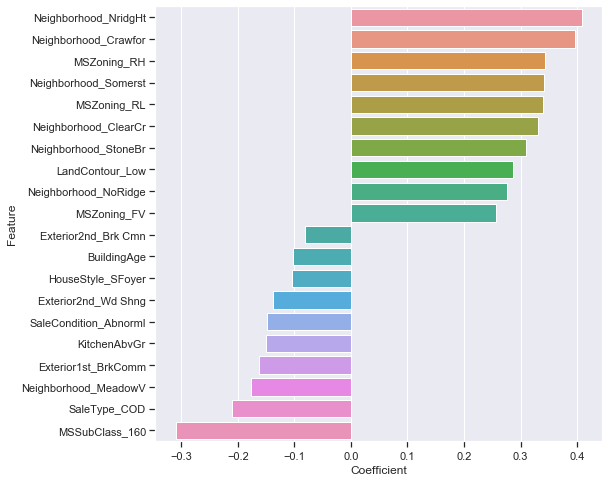

In [141]:
plt.figure(figsize = (8, 8))
sns.barplot(data = top_params_ridge, y = 'Feature', x = 'Coefficient')
plt.show()

In [142]:
# r2 score in train data set

y_train_pred = ridge.predict(X_train)
print(r2_score(y_true = y_train, y_pred = y_train_pred))

0.9117705972923494


In [143]:
# r2 score in test data set

y_test_pred = ridge.predict(X_test)
print(r2_score(y_true = y_test, y_pred = y_test_pred))

0.8830244411192802


---

## 2.5. Lasso Regression

In [144]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [145]:
%matplotlib inline

### 2.5.1. Grid Search to find Optimal Alpha

In [146]:
# list of alpha values for hyper parameter tuning

params = {'alpha': [0.00005, 0.0001, 0.0002, 0.0005, 
                    0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 
                    0.01, 0.02, 0.05]}

lasso = Lasso()

# cross validation

folds = 5

model = GridSearchCV(estimator = lasso, 
                     param_grid = params, 
                     scoring = 'neg_mean_absolute_error', 
                     cv = folds, 
                     return_train_score=True,
                     verbose = 1)            

model.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [5e-05, 0.0001, 0.0002, 0.0005, 0.001, 0.002,
                                   0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
                                   0.009, 0.01, 0.02, 0.05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [147]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha             params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score  split0_train_score  split1_train_score  split2_train_score  split3_train_score  split4_train_score  mean_train_score  std_train_score
0       0.053261      0.022098         0.001795        0.000399       5e-05   {'alpha': 5e-05}          -0.234105          -0.218496          -0.259203          -0.217764          -0.224448        -0.230807        0.015351                7           -0.204126           -0.182509           -0.192398           -0.209964           -0.207799         -0.199359         0.010381
1       0.034112      0.019801         0.000996        0.000003      0.0001  {'alpha': 0.0001}          -0.232741          -0.217794          -0.257993          -0.215419          -0.223225        -0.229438        0.015465                6           -0.203968           -0.182391           -0.192441           -0.209606           -0.207525         -0.199186         0.010281
2       0.066124      0.003020         0.001197        0.000399      0.0002  {'alpha': 0.0002}          -0.230910          -0.217194          -0.255444          -0.211902          -0.222081        -0.227510        0.015299                4           -0.204030           -0.182438           -0.193012           -0.208928           -0.207056         -0.199093         0.009989
3       0.057505      0.000967         0.001596        0.000489      0.0005  {'alpha': 0.0005}          -0.229005          -0.217700          -0.254402          -0.204784          -0.221741        -0.225530        0.016434                1           -0.205106           -0.183938           -0.195219           -0.209641           -0.207761         -0.200333         0.009587
4       0.030119      0.003645         0.001197        0.000399       0.001   {'alpha': 0.001}          -0.228245          -0.223827          -0.252428          -0.202274          -0.224384        -0.226233        0.015951                2           -0.208286           -0.188733           -0.197622           -0.212702           -0.211844         -0.203837         0.009266

In [148]:
model.best_params_

{'alpha': 0.0005}

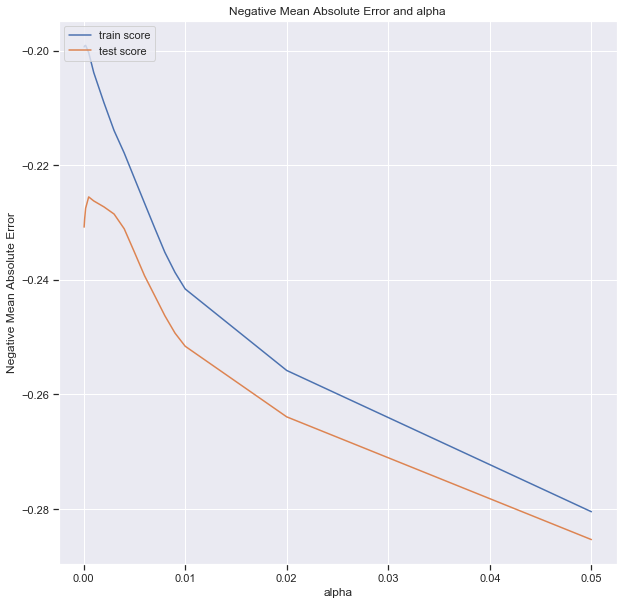

In [149]:
# plotting mean test and train scoes with alpha 
plt.figure(figsize=(10,10)) 

cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

### 2.5.2. Building the Model with Optimal Alpha

In [150]:
lasso = Lasso(alpha = 0.0005)      
lasso.fit(X_train, y_train)

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [151]:
lasso.intercept_

-3.825467622089049

In [152]:
lasso.coef_  # coefficient for different features

array([ 0.1501322 ,  0.094772  , -0.03388887,  0.02136082,  0.00334555,
        0.        ,  0.1902256 ,  0.03157858,  0.02034936, -0.00383917,
        0.31015443,  0.15071063,  0.05818803,  0.11262412,  0.09514159,
       -0.12052926,  0.03769315,  0.18011856, -0.10295192,  0.00881063,
        0.09232551, -0.33282366,  0.00156435,  0.19937272, -0.        ,
        0.13317332,  0.14391184,  0.07042999,  0.10757339,  0.01868262,
        0.20986622,  0.31157608,  0.21174537,  0.1360063 , -0.        ,
        0.        ,  0.15836638,  0.34562839,  0.06121508,  0.44014531,
        0.04265769, -0.20208622,  0.00766191,  0.29989937,  0.44276293,
        0.1805223 ,  0.05278355,  0.38525497,  0.36438923,  0.11364356,
        0.18059194,  0.17364022,  0.03664888,  0.11816293,  0.        ,
        0.        ,  0.02926966,  0.04362514,  0.03332334,  0.05191828,
        0.        ,  0.22237659, -0.05310045, -0.        , -0.        ,
       -0.26768271,  0.2457275 , -0.        ,  0.04960081,  0.07

Many of the coefficients become 0 and thus Lasso helps us in feature selection also.

In [153]:
coeff_lasso = pd.DataFrame(columns = ['Feature', 'Coefficient'])

coeff_lasso['Feature']     = X_train.columns
coeff_lasso['Coefficient'] = [round(x, 3) for x in list(lasso.coef_)]

In [154]:
coeff_lasso[coeff_lasso['Coefficient'] != 0].shape

(93, 2)

In [155]:
coeff_lasso = coeff_lasso.sort_values(by = 'Coefficient', ascending = False)

In [156]:
# to find the top 10 positive influencers and top 10 negative influencers

top_params_lasso = pd.concat([coeff_lasso.head(10), coeff_lasso.tail(10)])

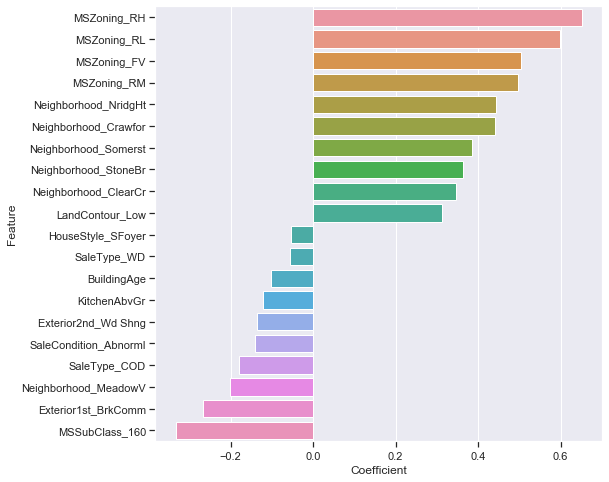

In [157]:
plt.figure(figsize = (8, 8))
sns.barplot(data = top_params_lasso, y = 'Feature', x = 'Coefficient')
plt.show()

In [158]:
# r2 score in train data set

y_train_pred = lasso.predict(X_train)
print(r2_score(y_true = y_train, y_pred = y_train_pred))

0.912769531555037


In [159]:
# r2 score in test data set

y_test_pred = lasso.predict(X_test)
print(r2_score(y_true = y_test, y_pred = y_test_pred))

0.8840901296140995


The important predictor variables in the model are:

 - MSZoning, Neighborhood, Land Contour - postive influencers (increases the price)
 - House Style, Building Age, KitchenAbvGr - negative influencers (reduces the price)
 
The variables are more or less the same in Ridge and Lasso Regression.

---

# 3. Assignment Part 2 - Questions

__Question 1:__ What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?

__Question 2:__ You have determined optimal value of lambda for ridge & lasso regression. Which one will you choose to apply and why?

__Question 3:__ After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

__Question 4:__ How can you make sure that a model is robust and generalisable? What are the implications of the same for the accuracy of the model and why?

---

## 3.1. Doubling the Alpha Value

__What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?__

 - Optimal value of alpha for Ridge Regression: 3 
 - Optimal value of alpha for Lasso Regression: 0.0005 

We will double the values and build the model.

### 3.1.1. Ridge Regression with Double the Value of Alpha

The optimal alpha for ridge regression is 3. Let us see what happens if we double it i.e. alpha = 6

In [160]:
ridge2 = Ridge(alpha = 6)
ridge2.fit(X_train, y_train)

Ridge(alpha=6, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [161]:
ridge2.intercept_

-3.4587648147576044

In [162]:
coeff_ridge2 = pd.DataFrame(columns = ['Feature', 'Coefficient'])

coeff_ridge2['Feature']     = X_train.columns
coeff_ridge2['Coefficient'] = [round(x, 3) for x in list(ridge2.coef_)]

In [163]:
coeff_ridge2[coeff_ridge2['Coefficient'] != 0].shape

(119, 2)

In [164]:
coeff_ridge2 = coeff_ridge2.sort_values(by = 'Coefficient', ascending = False)

In [165]:
top_params_ridge2 = pd.concat([coeff_ridge2.head(10), coeff_ridge2.tail(10)])

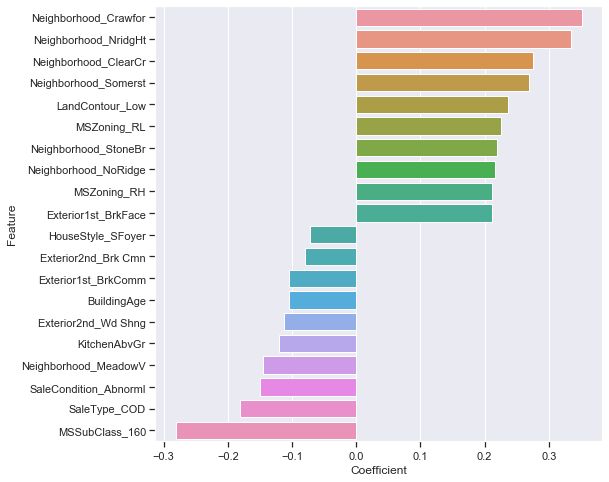

In [166]:
plt.figure(figsize = (8, 8))
sns.barplot(data = top_params_ridge2, y = 'Feature', x = 'Coefficient')
plt.show()

In [167]:
# r2 score in train data set

y_train_pred = ridge2.predict(X_train)
print(r2_score(y_true = y_train, y_pred = y_train_pred))

0.9081160406029689


In [168]:
# r2 score in test data set

y_test_pred = ridge2.predict(X_test)
print(r2_score(y_true = y_test, y_pred = y_test_pred))

0.8841733525405403


### 3.1.2. Lasso Regression with Double the Value of Alpha

In [169]:
lasso2 = Lasso(alpha = 0.001)      
lasso2.fit(X_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [170]:
lasso2.intercept_

-3.4148378577427616

In [171]:
coeff_lasso2 = pd.DataFrame(columns = ['Feature', 'Coefficient'])

coeff_lasso2['Feature']     = X_train.columns
coeff_lasso2['Coefficient'] = [round(x, 3) for x in list(lasso2.coef_)]

In [172]:
coeff_lasso2[coeff_lasso2['Coefficient'] != 0].shape

(77, 2)

In [173]:
coeff_lasso2 = coeff_lasso2.sort_values(by = 'Coefficient', ascending = False)

In [174]:
top_params_lasso2 = pd.concat([coeff_lasso2.head(10), coeff_lasso2.tail(10)])

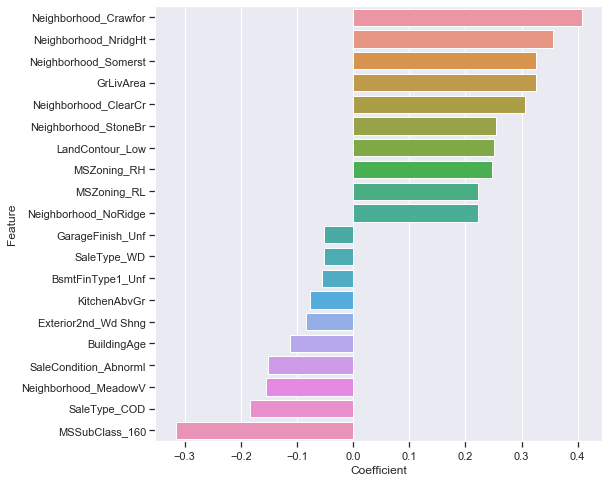

In [175]:
plt.figure(figsize = (8, 8))
sns.barplot(data = top_params_lasso2, y = 'Feature', x = 'Coefficient')
plt.show()

In [176]:
# r2 score in train data set

y_train_pred = lasso2.predict(X_train)
print(r2_score(y_true = y_train, y_pred = y_train_pred))

0.9062759952063996


In [177]:
# r2 score in test data set

y_test_pred = lasso2.predict(X_test)
print(r2_score(y_true = y_test, y_pred = y_test_pred))

0.8841827344087906


---

## 3.2. Model Selection

__You have determined the optimal value of lambda for ridge and lasso regression during the assignment. Now, which one will you choose to apply and why?__ Go with Lasso Model (it is simpler) if the cost of computation is not an issue.

We have applied RFE to reduce the number of features to 120 and then built the model using Ridge and Lasso Regularization with optimal alpha (hyper parameter). The results are shown below:

|Regularization|Optimal Alpha|r2 Score in Train|r2 Score in Test|Number of Features|
|:---|---:|---:|---:|---:|
|Lasso (L1)|0.0005|0.913|0.884|93|
|Ridge (L2)|3|0.912|0.883|119|

The model given by Lasso Regression is simple with lesser number of features. So, provided the computational intense calculations are acceptable we will go with the Lasso Model. The r2 score of Lasso model is bit better than the Ridge. Another option is to use RFE to reduce the number of features further and then apply Ridge Regression.

---

## 3.3. Unavailability of Top 5 Predictor Variables

__After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?__

The five important predictor variable are: MSZoning, Neighborhood, Land Contour, Building Age, KitchenAbvGr. 

Let us drop these columns and build the model.

In [178]:
dfcopy.shape

(1460, 71)

In [179]:
dfcopy.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice', 'SalePriceLog', 'BuildingAge', 'RemodeledAge', 'GarageAge',
       'Typical

### 3.3.1. Creating Dummies

In [180]:
# Drop top 5 predictor Variables

dfcopy.drop(columns = ['MSZoning', 'Neighborhood', 'LandContour', 'HouseStyle', 'BuildingAge'], inplace = True)

In [181]:
# Creating Dummies

dummy_set1 = ['MSSubClass', 'LotConfig', 'Condition1', 'BldgType',
              'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation']

dummy_set2 = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'MasVnrType',
              'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType', 'SaleCondition']

# We will create dummies with drop_first = True

dfcopy = pd.get_dummies(dfcopy, columns = dummy_set1, drop_first = True)

# We will create dummies with drop_first = False and then manually remove certain columns

dfcopy = pd.get_dummies(dfcopy, columns = dummy_set2, drop_first = False)

cols_to_drop = ['BsmtExposure_NA', 'BsmtFinType2_NA', 'BsmtFinType1_NA',
                'Electrical_Mix', 'MasVnrType_None', 'GarageType_NA','GarageFinish_NA',
                'PavedDrive_P', 'SaleType_Oth', 'SaleCondition_AdjLand']
                
dfcopy.drop(columns = cols_to_drop, inplace = True)

In [182]:
dfcopy.shape

(1460, 164)

### 3.3.2. Train Test Split & Scaling

In [183]:
# train test split

train, test = train_test_split(dfcopy, train_size = 0.7, test_size = 0.3, random_state = 100)

In [184]:
# scaling of the numeric features

features = ['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'WoodDeckSF', 'GarageArea', 'BsmtUnfSF', 
            'TotalBsmtSF', 'BsmtFinSF1', 'LotFrontage', 'LotArea', 'MasVnrArea', 'LowQualFinSF', 
            'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'BsmtFinSF2', 
            'MiscVal', 'SalePrice', 'SalePriceLog', 'RemodeledAge', 'GarageAge']

scaler = StandardScaler()

train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

In [185]:
y_train = train.pop('SalePriceLog')
X_train = train.drop('SalePrice', axis = 1)
y_test = test.pop('SalePriceLog')
X_test = test.drop('SalePrice', axis = 1)

### 3.3.3. Ridge Regression

In [186]:
# Grid Search to find optimal alpha

params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation

folds = 5

model = GridSearchCV(estimator = ridge, 
                     param_grid = params, 
                     scoring= 'neg_mean_absolute_error', 
                     cv = folds, 
                     return_train_score=True,
                     verbose = 1)            

model.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [187]:
model.best_params_

{'alpha': 50}

In [188]:
# building the model with optimal alpha

ridge3 = Ridge(alpha = 50)
ridge3.fit(X_train, y_train)

Ridge(alpha=50, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

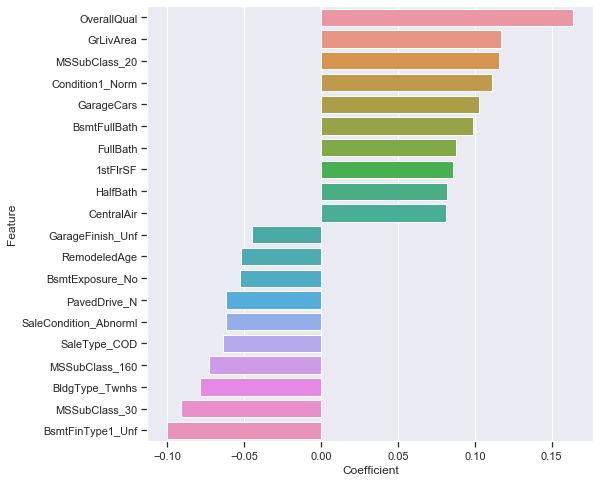

In [189]:
# identifying the top 10 positive influencers and top 10 negative influencers

coeff_ridge3 = pd.DataFrame(columns = ['Feature', 'Coefficient'])

coeff_ridge3['Feature']     = X_train.columns
coeff_ridge3['Coefficient'] = [round(x, 3) for x in list(ridge3.coef_)]

coeff_ridge3 = coeff_ridge3.sort_values(by = 'Coefficient', ascending = False)
top_params_ridge3 = pd.concat([coeff_ridge3.head(10), coeff_ridge3.tail(10)])

plt.figure(figsize = (8, 8))

sns.barplot(data = top_params_ridge3, y = 'Feature', x = 'Coefficient')

In [190]:
coeff_ridge3[coeff_ridge3['Coefficient'] != 0].shape

(156, 2)

In [191]:
# r2 score in train data set

y_train_pred = ridge3.predict(X_train)
print(r2_score(y_true = y_train, y_pred = y_train_pred))

0.8925503208000829


In [192]:
# r2 score in test data set

y_test_pred = ridge3.predict(X_test)
print(r2_score(y_true = y_test, y_pred = y_test_pred))

0.8779299353871005


### 3.3.4. Lasso Regression

In [193]:
# Grid Search to find optimal alpha

params = {'alpha': [0.00005, 0.0001, 0.0002, 0.0005, 
                    0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 
                    0.01, 0.02, 0.05]}

lasso = Lasso()

# cross validation

folds = 5

model = GridSearchCV(estimator = lasso, 
                     param_grid = params, 
                     scoring = 'neg_mean_absolute_error', 
                     cv = folds, 
                     return_train_score=True,
                     verbose = 1)            

model.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    2.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [5e-05, 0.0001, 0.0002, 0.0005, 0.001, 0.002,
                                   0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
                                   0.009, 0.01, 0.02, 0.05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [194]:
model.best_params_

{'alpha': 0.002}

In [195]:
# building the model with the optimal value for alpha

lasso3 = Lasso(alpha = 0.002)      
lasso3.fit(X_train, y_train)

Lasso(alpha=0.002, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

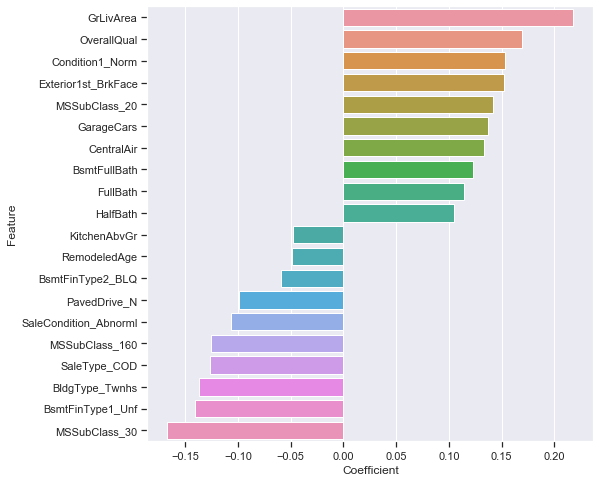

In [196]:
# identifying the top 10 positive influencers and top 10 negative influencers

coeff_lasso3 = pd.DataFrame(columns = ['Feature', 'Coefficient'])

coeff_lasso3['Feature']     = X_train.columns
coeff_lasso3['Coefficient'] = [round(x, 3) for x in list(lasso3.coef_)]

coeff_lasso3 = coeff_lasso3.sort_values(by = 'Coefficient', ascending = False)

top_params_lasso3 = pd.concat([coeff_lasso3.head(10), coeff_lasso3.tail(10)])

plt.figure(figsize = (8, 8))

sns.barplot(data = top_params_lasso3, y = 'Feature', x = 'Coefficient')

In [197]:
coeff_lasso3[coeff_lasso3['Coefficient'] != 0].shape

(81, 2)

In [198]:
# r2 score in train data set

y_train_pred = lasso3.predict(X_train)
print(r2_score(y_true = y_train, y_pred = y_train_pred))

0.8937917450573936


In [199]:
# r2 score in test data set

y_test_pred = lasso3.predict(X_test)
print(r2_score(y_true = y_test, y_pred = y_test_pred))

0.880045932112308


The optimal alpha for Ridge Regression is __50__ and for Lasso Regression it is __0.002__. 

The new predictor variables are: GrLiveArea, OverallQual, Condition1, GarageCars, CentralAir. 

---

## 3.4. Robust and Generalizable Model

__How can you make sure that a model is robust and generalisable? What are the implications of the same for the accuracy of the model and why?__

A simple model is robust and generalizable compared to a complex model. How do we know whether a model is complex or not? One way is to go by the number of parameters: lesser the parameters, simpler is the model. Or lesser the coefficient values for the parameters, simpler is the model. Simple models have low variance and high bias, whereas complex models have low bias and high variance. We have to ensure that the model is not oversimplified, which may result in underfitting. As a result the model will not perform well when we apply it on the test data. On the other hand, a complex model almost memorizes the train data, and does not generalize on the test data which it has not seen before. 

To make sure that the model is robust and generalizable we need to tune the hyper parameter, which, in the case of Ridge and Lasso regression, is the lambda value (or alpha) for the regularization term used for simplifying the model.

Bias quantifies how accurate the model can describe the actual task at hand i.e. how accurately it is likely to be on future (test) data. Variance measures how flexible the model is with respect to changes in the training data. As complexity increases, bias reduces and variance increases. The expected total error of a model is the sum of the errors in bias and the variance. We aim to find the optimal point where the total model error is the least so that we can get a model with a reasonable accuracy, but without compromising on the flexibility to generalize. 

In our model, we see that the r2 score on the train and test data are very close to each other, indicating that the model is able to generalize on unseen data and at the same time not over simplified.

---